

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
# pip install -U tensorflow_hub 
# pip install joblib
# pip install -U scikit-learn 
# pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn
# pip install transformers  

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-10-03 05:02:49,811: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json


## Get Data

### Download Data 

In [22]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

170498071/170498071 [==============================] - 14s 0us/step
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [23]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [24]:
i = 0
image_folder_path = os.path.join(params.data_path, 'data', f'image_{params.train_image_count}')
if not os.path.exists(image_folder_path):
    os.makedirs(image_folder_path)
for train_image, train_label  in zip(train_images, train_labels):
    i = i + 1
    image = Image.fromarray(train_image)
    image_path = os.path.join(image_folder_path, f"{i}.png")
    image.save(image_path)  

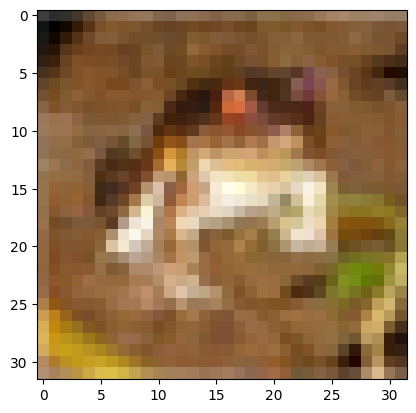

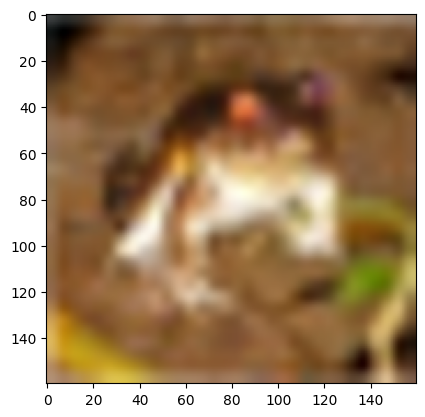

(32, 32, 3) (160, 160, 3)


In [25]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [26]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

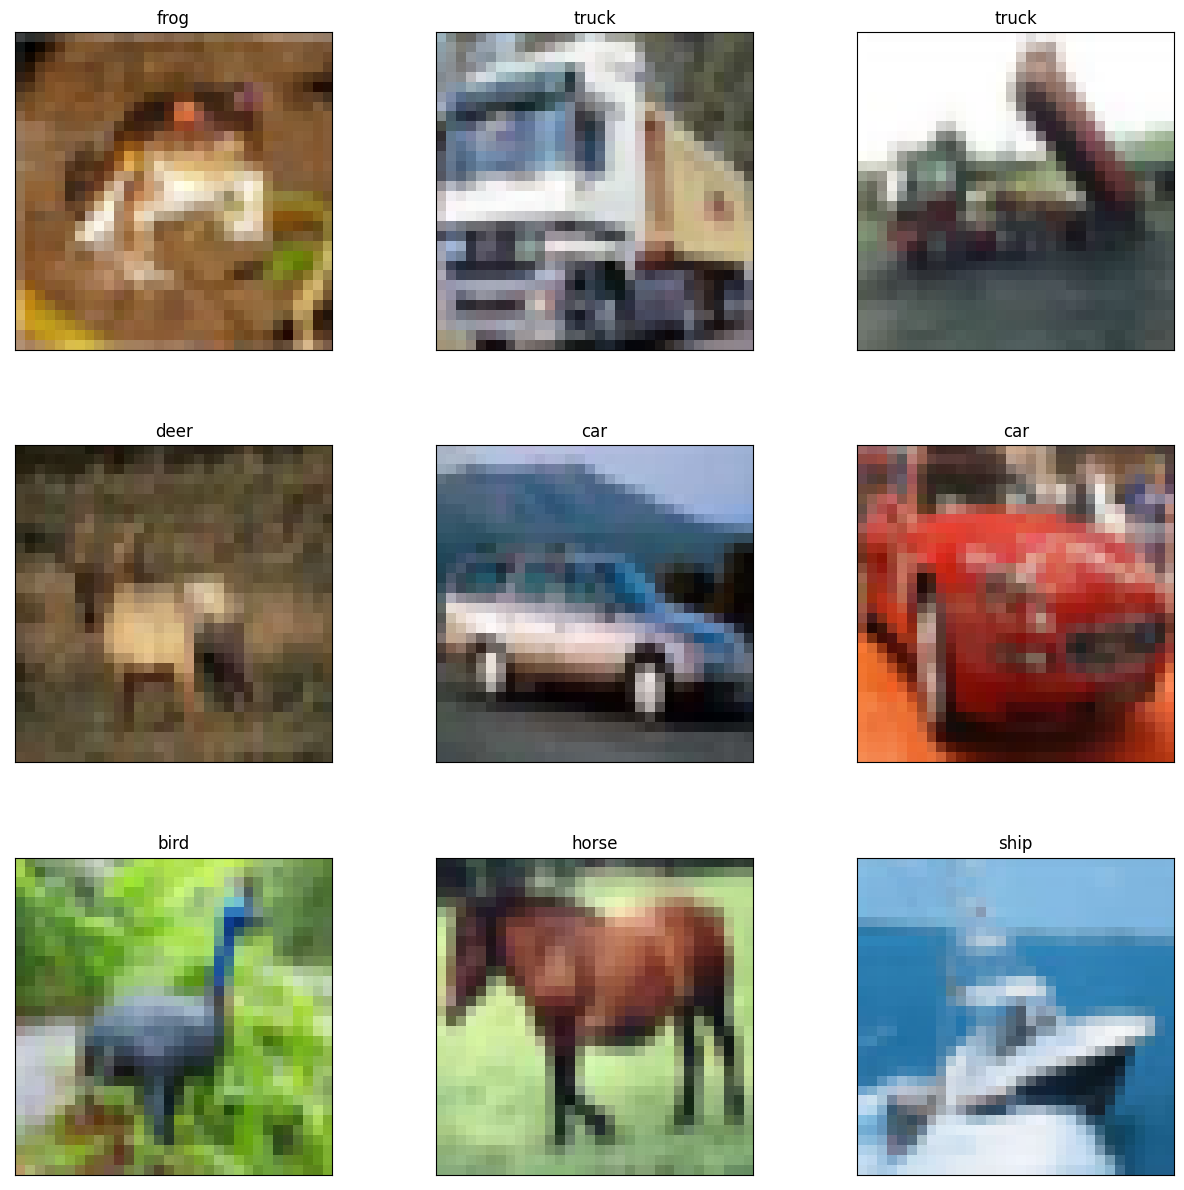

In [27]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

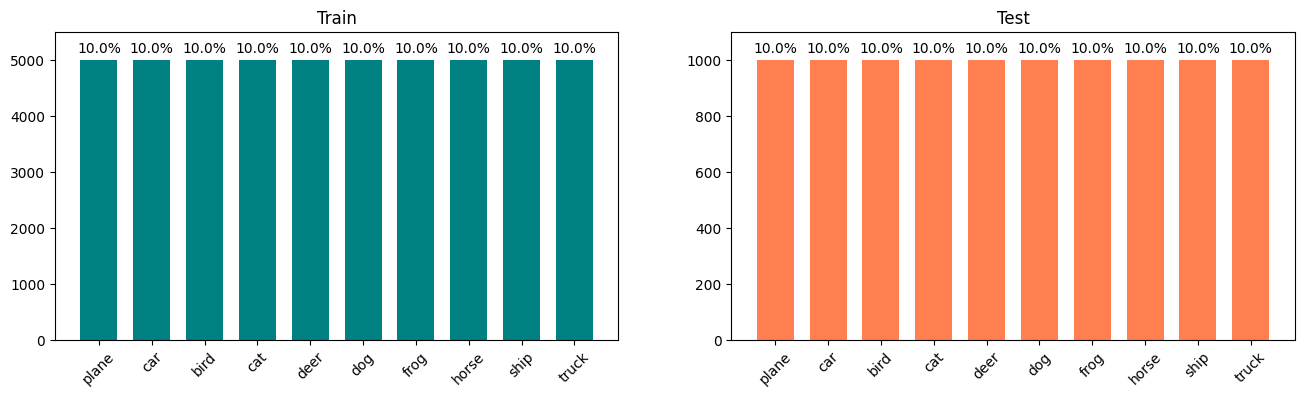

In [28]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [29]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [30]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [31]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

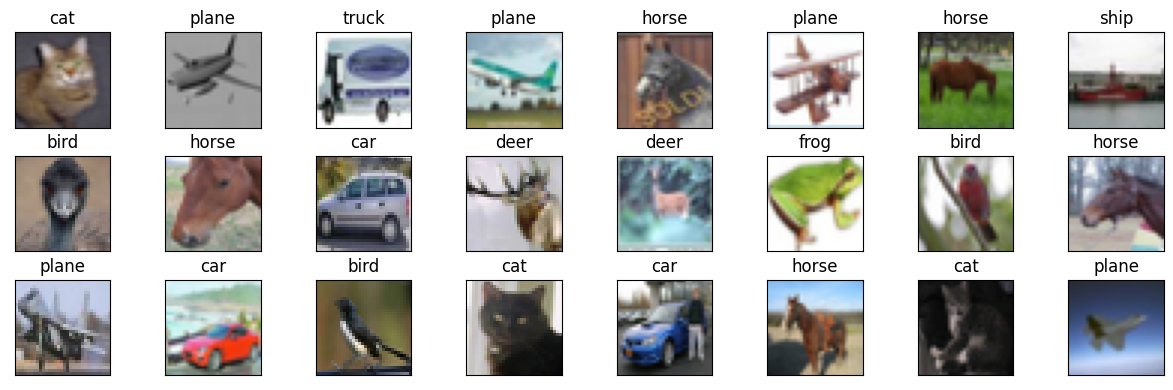

In [32]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [33]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

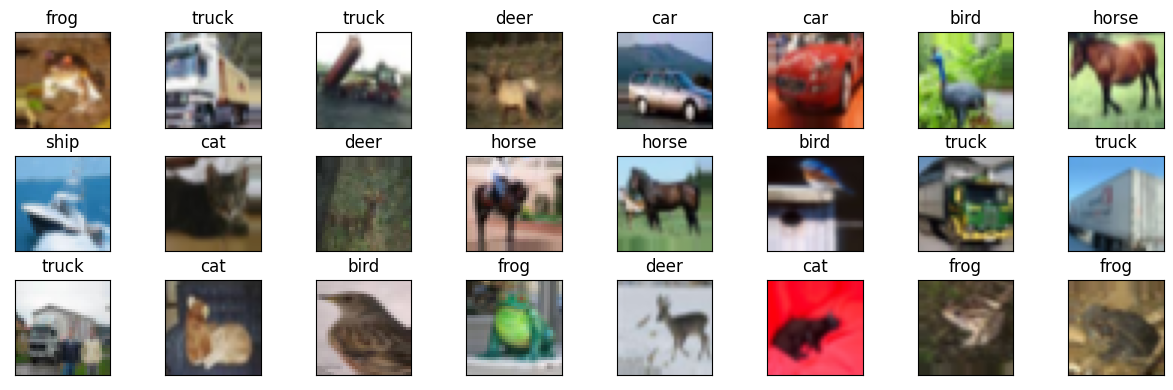

In [34]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

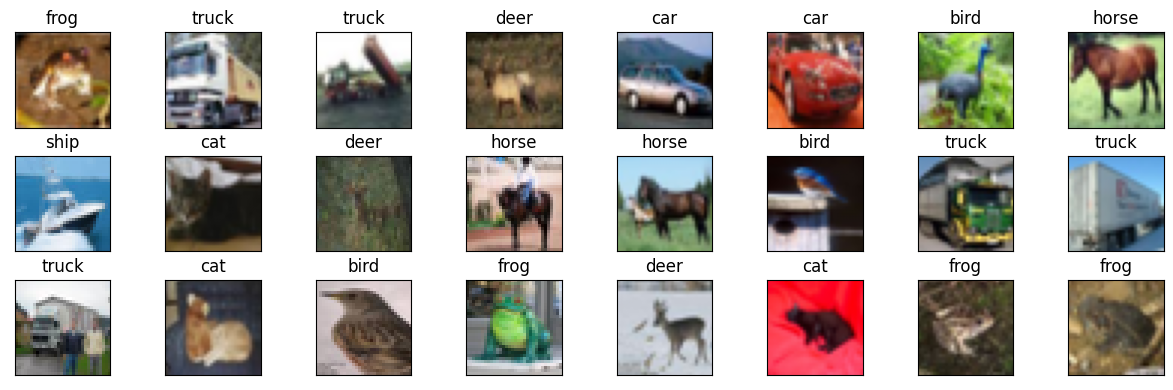

In [35]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [36]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [37]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


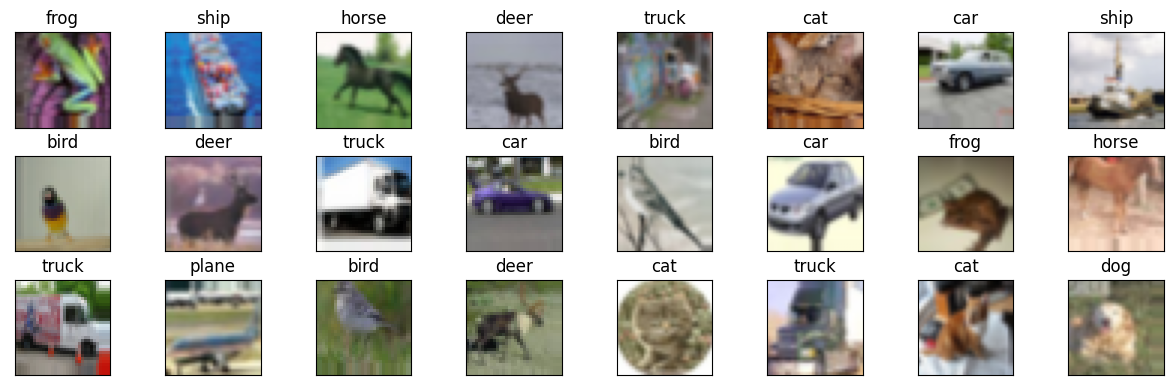

In [38]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [39]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-10-02 05:28:03,165: INFO: model_params.mlp1.dropout=0.1
2022-10-02 05:28:03,166: INFO: model_params.mlp1.layer_count=1
2022-10-02 05:28:03,167: INFO: model_params.mlp1.units=128
2022-10-02 05:28:03,218: INFO: learning_rate=0.001
2022-10-02 05:28:03,218: INFO: model_params.mlp1.clip_value=None
2022-10-02 05:28:03,228: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-10-02 05:28:03,243: INFO: model_params.mlp1.epochs=90
2022-10-02 05:28:03,244: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1, monitor=val_accuracy)
2022-10-02 05:28:03,245: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-10-02 05:28:03,245: INFO: use LearningRateScheduler()
2022-10-02 05:28:03,246: INFO: steps_per_epoch=1562
2022-10-02 05:28:03,247: INFO: start training
2022-10-02 05:28:03,247: INFO: use_class_weight=False


Epoch 1/90
1553/1562 [============================>.] - ETA: 0s - loss: 1.9677 - accuracy: 0.2784INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:09,528: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 6s 3ms/step - loss: 1.9670 - accuracy: 0.2787 - val_loss: 1.8542 - val_accuracy: 0.3209 - lr: 0.0010
Epoch 2/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.8720 - accuracy: 0.3165INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:14,168: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8720 - accuracy: 0.3166 - val_loss: 1.8140 - val_accuracy: 0.3327 - lr: 0.0010
Epoch 3/90
1546/1562 [============================>.] - ETA: 0s - loss: 1.8415 - accuracy: 0.3302INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:18,995: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8409 - accuracy: 0.3306 - val_loss: 1.7640 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 4/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.8247 - accuracy: 0.3335INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:23,667: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8247 - accuracy: 0.3335 - val_loss: 1.7643 - val_accuracy: 0.3643 - lr: 0.0010
Epoch 5/90
1545/1562 [============================>.] - ETA: 0s - loss: 1.8092 - accuracy: 0.3408INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:28,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8091 - accuracy: 0.3408 - val_loss: 1.7617 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 6/90
1551/1562 [============================>.] - ETA: 0s - loss: 1.7983 - accuracy: 0.3443INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:33,070: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7982 - accuracy: 0.3444 - val_loss: 1.7488 - val_accuracy: 0.3715 - lr: 0.0010
Epoch 7/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7905 - accuracy: 0.3491 - val_loss: 1.7520 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 8/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7794 - accuracy: 0.3516 - val_loss: 1.7500 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 9/90
1559/1562 [============================>.] - ETA: 0s - loss: 1.7762 - accuracy: 0.3541INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:45,834: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7763 - accuracy: 0.3540 - val_loss: 1.7273 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7614 - accuracy: 0.3594 - val_loss: 1.7274 - val_accuracy: 0.3780 - lr: 0.0010
Epoch 11/90
1549/1562 [============================>.] - ETA: 0s - loss: 1.7600 - accuracy: 0.3589INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:28:54,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7597 - accuracy: 0.3589 - val_loss: 1.7111 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 12/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7494 - accuracy: 0.3629 - val_loss: 1.7115 - val_accuracy: 0.3757 - lr: 0.0010
Epoch 13/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.7482 - accuracy: 0.3613INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:29:03,427: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7481 - accuracy: 0.3613 - val_loss: 1.6995 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 14/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7450 - accuracy: 0.3652 - val_loss: 1.7022 - val_accuracy: 0.3849 - lr: 0.0010
Epoch 15/90
1549/1562 [============================>.] - ETA: 0s - loss: 1.7420 - accuracy: 0.3638INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:29:12,185: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7418 - accuracy: 0.3637 - val_loss: 1.6965 - val_accuracy: 0.3884 - lr: 0.0010
Epoch 16/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7382 - accuracy: 0.3656 - val_loss: 1.7076 - val_accuracy: 0.3801 - lr: 0.0010
Epoch 17/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7336 - accuracy: 0.3698 - val_loss: 1.7164 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 18/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.7318 - accuracy: 0.3689INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:29:24,863: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7319 - accuracy: 0.3688 - val_loss: 1.6847 - val_accuracy: 0.3888 - lr: 0.0010
Epoch 19/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7283 - accuracy: 0.3706 - val_loss: 1.6976 - val_accuracy: 0.3843 - lr: 0.0010
Epoch 20/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7237 - accuracy: 0.3696 - val_loss: 1.6987 - val_accuracy: 0.3795 - lr: 0.0010
Epoch 21/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7259 - accuracy: 0.3730 - val_loss: 1.6992 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 22/90
1548/1562 [============================>.] - ETA: 0s - loss: 1.7192 - accuracy: 0.3731INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:29:41,578: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7189 - accuracy: 0.3731 - val_loss: 1.6850 - val_accuracy: 0.3894 - lr: 0.0010
Epoch 23/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.7201 - accuracy: 0.3719INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:29:46,470: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7200 - accuracy: 0.3718 - val_loss: 1.6843 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 24/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7183 - accuracy: 0.3741 - val_loss: 1.6900 - val_accuracy: 0.3912 - lr: 0.0010
Epoch 25/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7154 - accuracy: 0.3770 - val_loss: 1.6886 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 26/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7152 - accuracy: 0.3764 - val_loss: 1.6857 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 27/90
1542/1562 [============================>.] - ETA: 0s - loss: 1.7157 - accuracy: 0.3736INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:30:03,366: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7154 - accuracy: 0.3739 - val_loss: 1.6776 - val_accuracy: 0.3974 - lr: 0.0010
Epoch 28/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7123 - accuracy: 0.3758 - val_loss: 1.7126 - val_accuracy: 0.3827 - lr: 0.0010
Epoch 29/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7101 - accuracy: 0.3790 - val_loss: 1.6934 - val_accuracy: 0.3828 - lr: 0.0010
Epoch 30/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7087 - accuracy: 0.3773 - val_loss: 1.6830 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 31/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7081 - accuracy: 0.3782 - val_loss: 1.6884 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 32/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7061 - accuracy: 0.3780 - val_loss: 1.6934 - val_accuracy: 0.3863 - lr: 0.0010
Epoch 33/90
1562/1562 [==============================] - 4s 3ms/

2022-10-02 05:32:05,500: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6633 - accuracy: 0.3947 - val_loss: 1.6462 - val_accuracy: 0.4014 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/90
1542/1562 [============================>.] - ETA: 0s - loss: 1.6610 - accuracy: 0.3957INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:32:10,246: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6609 - accuracy: 0.3957 - val_loss: 1.6477 - val_accuracy: 0.4036 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6590 - accuracy: 0.3948 - val_loss: 1.6454 - val_accuracy: 0.4026 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6602 - accuracy: 0.3971 - val_loss: 1.6515 - val_accuracy: 0.3990 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/90
1553/1562 [============================>.] - ETA: 0s - loss: 1.6521 - accuracy: 0.3996INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:32:23,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6522 - accuracy: 0.3998 - val_loss: 1.6435 - val_accuracy: 0.4040 - lr: 1.0000e-04
Epoch 62/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6511 - accuracy: 0.3989 - val_loss: 1.6446 - val_accuracy: 0.4025 - lr: 1.0000e-04
Epoch 63/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6484 - accuracy: 0.4017 - val_loss: 1.6446 - val_accuracy: 0.4034 - lr: 1.0000e-04
Epoch 64/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.6478 - accuracy: 0.4037INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


2022-10-02 05:32:35,816: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6478 - accuracy: 0.4036 - val_loss: 1.6460 - val_accuracy: 0.4044 - lr: 1.0000e-04
Epoch 65/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6513 - accuracy: 0.4017 - val_loss: 1.6434 - val_accuracy: 0.4038 - lr: 1.0000e-04
Epoch 66/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6511 - accuracy: 0.4010 - val_loss: 1.6458 - val_accuracy: 0.4031 - lr: 1.0000e-04
Epoch 67/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6490 - accuracy: 0.4003 - val_loss: 1.6444 - val_accuracy: 0.4037 - lr: 1.0000e-04
Epoch 68/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6452 - accuracy: 0.4018 - val_loss: 1.6454 - val_accuracy: 0.4024 - lr: 1.0000e-04
Epoch 69/90
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6467 - accuracy: 0.4032 - val_loss: 1.6423 - val_accuracy: 0.4034 - lr: 1.0000e-04
Epoch 70/90
1562/1562 [=================

2022-10-02 05:34:21,644: INFO: finish training [elapsed time: 378.40 seconds]


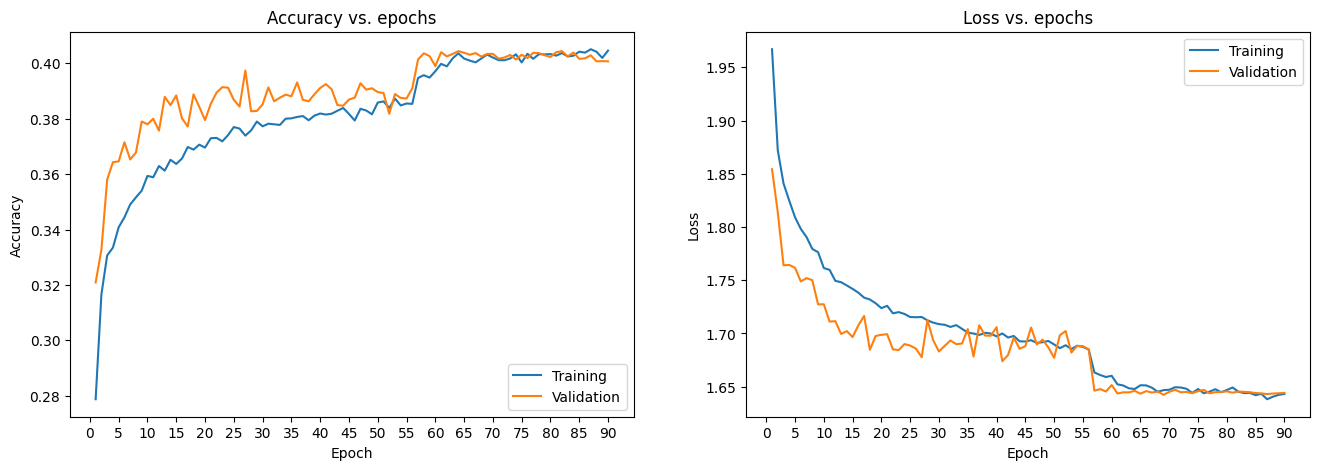

2022-10-02 05:34:22,191: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-10-02 05:34:31,087: INFO: test loss:1.6460
2022-10-02 05:34:31,088: INFO: test accuracy:0.4044
2022-10-02 05:34:31,090: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 05:34:31,092: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 05:34:31,092: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 05:34:31,094: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


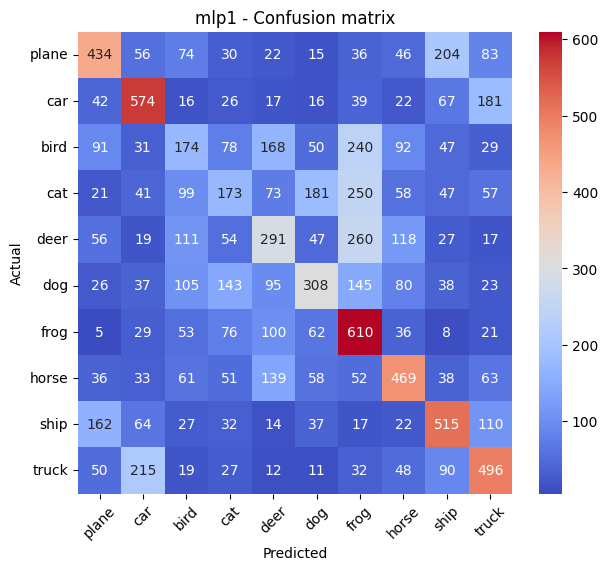

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_5000.ipynb         394634       378.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-10-02 05:34      1.5657      1.646          0.4377         0.4044   

   train_auc  test_auc  
1     0.8543    0.8349

In [40]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-10-02 05:34:32,522: INFO: model_params.lenet1.dropout=0.2
2022-10-02 05:34:32,617: INFO: learning_rate=0.001
2022-10-02 05:34:32,618: INFO: model_params.lenet1.clip_value=None
2022-10-02 05:34:32,623: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-10-02 05:34:32,654: INFO: model_params.lenet1.epochs=90
2022-10-02 05:34:32,655: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1, monitor=val_accuracy)
2022-10-02 05:34:32,655: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-10-02 05:34:32,656: INFO: use LearningRateScheduler()
2022-10-02 05:34:32,657: INFO: steps_per_epoch=1562
2022-10-02 05:34:32,657: INFO: start training
2022-10-02 05:34:32,658: INFO: use_class_weight=False


Epoch 1/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.7895 - accuracy: 0.3467

2022-10-02 05:34:44,748: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:34:45,374: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 13s 6ms/step - loss: 1.7895 - accuracy: 0.3467 - val_loss: 1.7442 - val_accuracy: 0.3808 - lr: 0.0010
Epoch 2/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.4786 - accuracy: 0.4642

2022-10-02 05:34:54,214: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:34:54,924: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.4786 - accuracy: 0.4642 - val_loss: 1.3386 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 3/90
1557/1562 [============================>.] - ETA: 0s - loss: 1.3314 - accuracy: 0.5249

2022-10-02 05:35:03,581: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:04,392: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.3313 - accuracy: 0.5249 - val_loss: 1.3330 - val_accuracy: 0.5401 - lr: 0.0010
Epoch 4/90
1555/1562 [============================>.] - ETA: 0s - loss: 1.2498 - accuracy: 0.5555

2022-10-02 05:35:13,089: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:13,681: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.2499 - accuracy: 0.5555 - val_loss: 1.1350 - val_accuracy: 0.5932 - lr: 0.0010
Epoch 5/90
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1927 - accuracy: 0.5786 - val_loss: 1.5083 - val_accuracy: 0.5059 - lr: 0.0010
Epoch 6/90
1555/1562 [============================>.] - ETA: 0s - loss: 1.1471 - accuracy: 0.5963

2022-10-02 05:35:29,929: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:30,524: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.1472 - accuracy: 0.5964 - val_loss: 1.1552 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 7/90
1559/1562 [============================>.] - ETA: 0s - loss: 1.1181 - accuracy: 0.6064

2022-10-02 05:35:39,290: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:39,904: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.1181 - accuracy: 0.6064 - val_loss: 1.0423 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 8/90
1554/1562 [============================>.] - ETA: 0s - loss: 1.0887 - accuracy: 0.6153

2022-10-02 05:35:48,859: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:49,465: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.0888 - accuracy: 0.6153 - val_loss: 1.0076 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 9/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.0666 - accuracy: 0.6256

2022-10-02 05:35:58,075: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:35:58,675: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0667 - accuracy: 0.6256 - val_loss: 0.9866 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 7s 5ms/step - loss: 1.0430 - accuracy: 0.6325 - val_loss: 1.0535 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 11/90
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0242 - accuracy: 0.6376 - val_loss: 1.1762 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 12/90
1557/1562 [============================>.] - ETA: 0s - loss: 1.0099 - accuracy: 0.6469

2022-10-02 05:36:22,313: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:36:22,905: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0099 - accuracy: 0.6470 - val_loss: 0.9934 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 13/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.6503

2022-10-02 05:36:31,942: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:36:32,545: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9896 - accuracy: 0.6503 - val_loss: 0.9909 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 14/90
1552/1562 [============================>.] - ETA: 0s - loss: 0.9804 - accuracy: 0.6540

2022-10-02 05:36:41,325: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:36:42,147: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9804 - accuracy: 0.6539 - val_loss: 0.9756 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 15/90
1551/1562 [============================>.] - ETA: 0s - loss: 0.9718 - accuracy: 0.6579

2022-10-02 05:36:50,886: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:36:51,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9717 - accuracy: 0.6579 - val_loss: 0.9445 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 16/90
1557/1562 [============================>.] - ETA: 0s - loss: 0.9623 - accuracy: 0.6607

2022-10-02 05:37:00,590: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:37:01,203: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9627 - accuracy: 0.6607 - val_loss: 0.9450 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 17/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9464 - accuracy: 0.6679 - val_loss: 0.9751 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 18/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9389 - accuracy: 0.6693 - val_loss: 0.9687 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 19/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9322 - accuracy: 0.6711 - val_loss: 0.9644 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 20/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9197 - accuracy: 0.6772 - val_loss: 1.1975 - val_accuracy: 0.5837 - lr: 0.0010
Epoch 21/90
1556/1562 [============================>.] - ETA: 0s - loss: 0.9193 - accuracy: 0.6757

2022-10-02 05:37:39,963: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:37:40,560: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9193 - accuracy: 0.6757 - val_loss: 0.9175 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 22/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9105 - accuracy: 0.6806 - val_loss: 0.9423 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 23/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9045 - accuracy: 0.6796 - val_loss: 0.9662 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 24/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8954 - accuracy: 0.6843 - val_loss: 0.9616 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 25/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8902 - accuracy: 0.6868 - val_loss: 0.9197 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 26/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8865 - accuracy: 0.6881 - val_loss: 1.1194 - val_accuracy: 0.6241 - lr: 0.0010
Epoch 27/90
1562/1562 [==============================] - 7s 5ms/

2022-10-02 05:38:41,646: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:38:42,236: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8734 - accuracy: 0.6926 - val_loss: 0.9136 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 30/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.8661 - accuracy: 0.6955

2022-10-02 05:38:51,280: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:38:51,888: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.8662 - accuracy: 0.6955 - val_loss: 0.8990 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 31/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8616 - accuracy: 0.6975 - val_loss: 1.0093 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 32/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8622 - accuracy: 0.6974 - val_loss: 1.0198 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 33/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8570 - accuracy: 0.6989 - val_loss: 0.9724 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 34/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8544 - accuracy: 0.6998 - val_loss: 1.0614 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 35/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8504 - accuracy: 0.7000 - val_loss: 0.9135 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 36/90
1562/1562 [==============================] - 7s 5ms

2022-10-02 05:39:45,594: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:39:46,190: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8428 - accuracy: 0.7032 - val_loss: 0.8748 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 38/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8437 - accuracy: 0.7032 - val_loss: 1.0694 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 39/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8349 - accuracy: 0.7077 - val_loss: 1.1586 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 40/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8339 - accuracy: 0.7069 - val_loss: 0.9710 - val_accuracy: 0.6666 - lr: 0.0010
Epoch 41/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8259 - accuracy: 0.7086 - val_loss: 0.8910 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 42/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8320 - accuracy: 0.7076 - val_loss: 0.8997 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 43/90
1556/1562 [============================>.] - ETA: 0s

2022-10-02 05:40:32,774: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:40:33,363: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.8229 - accuracy: 0.7082 - val_loss: 0.8598 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 44/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8233 - accuracy: 0.7099 - val_loss: 0.8671 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 45/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8263 - accuracy: 0.7072 - val_loss: 0.8702 - val_accuracy: 0.6996 - lr: 0.0010
Epoch 46/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8180 - accuracy: 0.7115 - val_loss: 0.8890 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 47/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8111 - accuracy: 0.7128 - val_loss: 0.9232 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 48/90
1553/1562 [============================>.] - ETA: 0s - loss: 0.8094 - accuracy: 0.7144

2022-10-02 05:41:12,169: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:41:12,779: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.8089 - accuracy: 0.7145 - val_loss: 0.8428 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 49/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8102 - accuracy: 0.7152 - val_loss: 0.9063 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 50/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8099 - accuracy: 0.7141 - val_loss: 1.1078 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 51/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8068 - accuracy: 0.7159 - val_loss: 0.8903 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 52/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8053 - accuracy: 0.7177 - val_loss: 0.9282 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 53/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8021 - accuracy: 0.7177 - val_loss: 0.8952 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 54/90
1562/1562 [==============================] - 7s 5ms

2022-10-02 05:42:51,519: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:42:52,116: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7622 - accuracy: 0.7307 - val_loss: 0.8197 - val_accuracy: 0.7186 - lr: 1.0000e-04
Epoch 62/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7485 - accuracy: 0.7357 - val_loss: 0.8218 - val_accuracy: 0.7179 - lr: 1.0000e-04
Epoch 63/90
1556/1562 [============================>.] - ETA: 0s - loss: 0.7464 - accuracy: 0.7370

2022-10-02 05:43:08,237: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:43:08,828: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7465 - accuracy: 0.7369 - val_loss: 0.8176 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 64/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.7423 - accuracy: 0.7382

2022-10-02 05:43:17,840: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:43:18,720: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7424 - accuracy: 0.7382 - val_loss: 0.8144 - val_accuracy: 0.7242 - lr: 1.0000e-04
Epoch 65/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7364 - accuracy: 0.7417 - val_loss: 0.8205 - val_accuracy: 0.7202 - lr: 1.0000e-04
Epoch 66/90
1549/1562 [============================>.] - ETA: 0s - loss: 0.7366 - accuracy: 0.7390

2022-10-02 05:43:34,960: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:43:35,560: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7371 - accuracy: 0.7390 - val_loss: 0.8114 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 67/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7334 - accuracy: 0.7395 - val_loss: 0.8144 - val_accuracy: 0.7247 - lr: 1.0000e-04
Epoch 68/90
1553/1562 [============================>.] - ETA: 0s - loss: 0.7359 - accuracy: 0.7413

2022-10-02 05:43:51,851: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:43:52,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7363 - accuracy: 0.7410 - val_loss: 0.8126 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 69/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7333 - accuracy: 0.7424 - val_loss: 0.8183 - val_accuracy: 0.7213 - lr: 1.0000e-04
Epoch 70/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7337 - accuracy: 0.7407 - val_loss: 0.8171 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 71/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7285 - accuracy: 0.7432 - val_loss: 0.8101 - val_accuracy: 0.7253 - lr: 1.0000e-04
Epoch 72/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7323 - accuracy: 0.7426 - val_loss: 0.8239 - val_accuracy: 0.7202 - lr: 1.0000e-04
Epoch 73/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.7292 - accuracy: 0.7441

2022-10-02 05:44:31,151: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:44:31,807: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7297 - accuracy: 0.7439 - val_loss: 0.8057 - val_accuracy: 0.7270 - lr: 1.0000e-04
Epoch 74/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7303 - accuracy: 0.7418 - val_loss: 0.8234 - val_accuracy: 0.7247 - lr: 1.0000e-04
Epoch 75/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7271 - accuracy: 0.7444 - val_loss: 0.8085 - val_accuracy: 0.7249 - lr: 1.0000e-04
Epoch 76/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7297 - accuracy: 0.7448 - val_loss: 0.8189 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 77/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7293 - accuracy: 0.7417 - val_loss: 0.8134 - val_accuracy: 0.7225 - lr: 1.0000e-04
Epoch 78/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7197 - accuracy: 0.7466 - val_loss: 0.8120 - val_accuracy: 0.7249 - lr: 1.0000e-04
Epoch 79/90
1562/1562 [=================

2022-10-02 05:45:25,672: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:45:26,278: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7266 - accuracy: 0.7432 - val_loss: 0.8045 - val_accuracy: 0.7274 - lr: 1.0000e-04
Epoch 81/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7269 - accuracy: 0.7443 - val_loss: 0.8164 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 82/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7239 - accuracy: 0.7448 - val_loss: 0.8059 - val_accuracy: 0.7260 - lr: 1.0000e-04
Epoch 83/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7197 - accuracy: 0.7446 - val_loss: 0.8101 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 84/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7231 - accuracy: 0.7471 - val_loss: 0.8085 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 85/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7191 - accuracy: 0.7450 - val_loss: 0.8281 - val_accuracy: 0.7187 - lr: 1.0000e-04
Epoch 86/90
1562/1562 [================

2022-10-02 05:46:20,302: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


2022-10-02 05:46:20,899: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7230 - accuracy: 0.7463 - val_loss: 0.8065 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 88/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7187 - accuracy: 0.7467 - val_loss: 0.8359 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 89/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7263 - accuracy: 0.7444 - val_loss: 0.8044 - val_accuracy: 0.7278 - lr: 1.0000e-04
Epoch 90/90
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7219 - accuracy: 0.7462 - val_loss: 0.8087 - val_accuracy: 0.7250 - lr: 1.0000e-04


2022-10-02 05:46:43,474: INFO: finish training [elapsed time: 730.82 seconds]


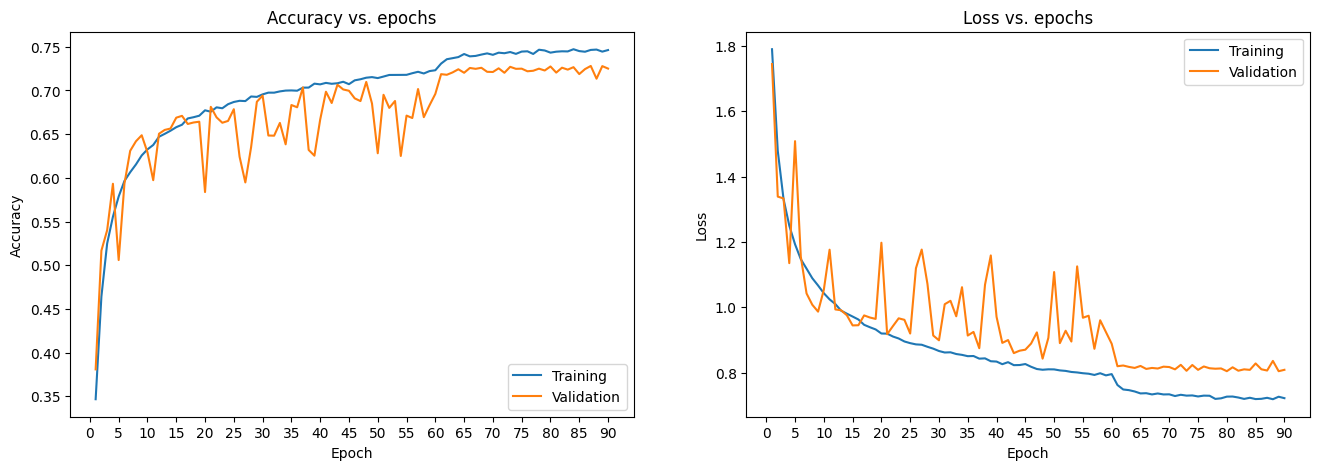

2022-10-02 05:46:43,923: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-10-02 05:46:55,686: INFO: test loss:0.8065
2022-10-02 05:46:55,686: INFO: test accuracy:0.7280
2022-10-02 05:46:55,688: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 05:46:55,689: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 05:46:55,690: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 05:46:55,691: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 05:46:55,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-10-02 05:46:56,016: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


313/313 [==============================] - 0s 1ms/step


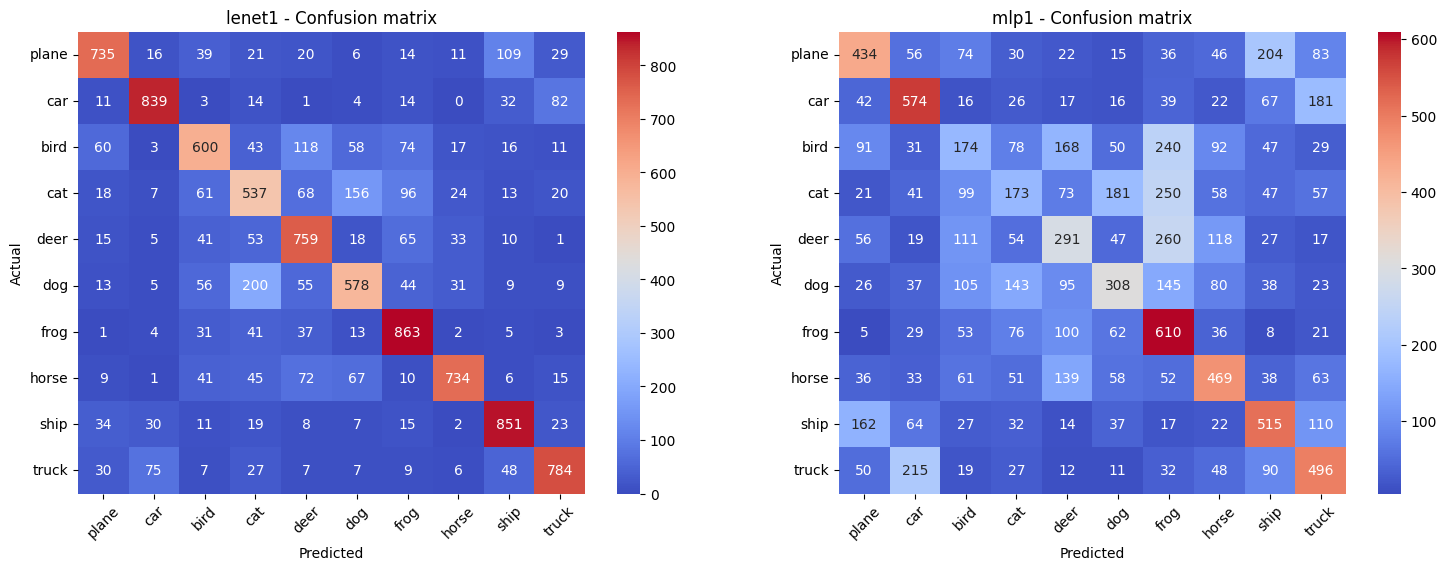

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_5000.ipynb          83170       730.8   
2       mlp1  cifar10_0816_cnt_5000.ipynb         394634       378.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-10-02 05:46      0.4656     0.8065          0.8413         0.7280   
2  2022-10-02 05:34      1.5657     1.6460          0.4377         0.4044   

   train_auc  test_auc  
1     0.9870    0.9608  
2     0.8543    0.8349

In [41]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-10-02 05:46:59,497: INFO: model_params.custom1.dropout=0.2
2022-10-02 05:46:59,603: INFO: learning_rate=0.001
2022-10-02 05:46:59,604: INFO: model_params.custom1.clip_value=None
2022-10-02 05:46:59,610: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-10-02 05:46:59,648: INFO: model_params.custom1.epochs=90
2022-10-02 05:46:59,649: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1, monitor=val_accuracy)
2022-10-02 05:46:59,650: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-10-02 05:46:59,650: INFO: use LearningRateScheduler()
2022-10-02 05:46:59,651: INFO: steps_per_epoch=1562
2022-10-02 05:46:59,652: INFO: start training
2022-10-02 05:46:59,653: INFO: use_class_weight=False


Epoch 1/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.6305 - accuracy: 0.4110

2022-10-02 05:47:10,972: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:47:11,723: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 12s 7ms/step - loss: 1.6302 - accuracy: 0.4112 - val_loss: 1.3576 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/90
1556/1562 [============================>.] - ETA: 0s - loss: 1.2856 - accuracy: 0.5420

2022-10-02 05:47:21,631: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:47:22,304: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.2854 - accuracy: 0.5420 - val_loss: 1.1486 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 3/90
1562/1562 [==============================] - 9s 6ms/step - loss: 1.1462 - accuracy: 0.5933 - val_loss: 1.2006 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 4/90
1562/1562 [==============================] - ETA: 0s - loss: 1.0640 - accuracy: 0.6255

2022-10-02 05:47:41,194: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:47:41,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.0640 - accuracy: 0.6255 - val_loss: 0.9714 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 5/90
1558/1562 [============================>.] - ETA: 0s - loss: 1.0048 - accuracy: 0.6465

2022-10-02 05:47:51,911: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:47:52,581: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.0049 - accuracy: 0.6465 - val_loss: 0.9246 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 6/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.9598 - accuracy: 0.6607

2022-10-02 05:48:02,667: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:48:03,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.9598 - accuracy: 0.6607 - val_loss: 0.8579 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 7/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.9276 - accuracy: 0.6737

2022-10-02 05:48:13,727: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:48:14,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.9277 - accuracy: 0.6736 - val_loss: 0.8399 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 8/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8959 - accuracy: 0.6839 - val_loss: 1.0508 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 9/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.8745 - accuracy: 0.6956

2022-10-02 05:48:33,021: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:48:33,699: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.8746 - accuracy: 0.6956 - val_loss: 0.7863 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8627 - accuracy: 0.6975 - val_loss: 0.7987 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 11/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8380 - accuracy: 0.7081 - val_loss: 0.9987 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 12/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.8276 - accuracy: 0.7123 - val_loss: 0.8726 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 13/90
1556/1562 [============================>.] - ETA: 0s - loss: 0.8092 - accuracy: 0.7151

2022-10-02 05:49:09,297: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:49:09,973: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.8092 - accuracy: 0.7151 - val_loss: 0.7590 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 14/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.8007 - accuracy: 0.7196 - val_loss: 0.7798 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 15/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7851 - accuracy: 0.7262 - val_loss: 0.8937 - val_accuracy: 0.6996 - lr: 0.0010
Epoch 16/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7774 - accuracy: 0.7293 - val_loss: 0.8361 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 17/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7660 - accuracy: 0.7342 - val_loss: 0.7874 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 18/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.7616 - accuracy: 0.7334 - val_loss: 0.8988 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 19/90
1556/1562 [============================>.] - ETA: 0

2022-10-02 05:50:02,980: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:50:03,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7527 - accuracy: 0.7369 - val_loss: 0.7445 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 20/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.7345 - accuracy: 0.7446 - val_loss: 0.7804 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 21/90
1555/1562 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.7425

2022-10-02 05:50:22,401: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:50:23,079: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7380 - accuracy: 0.7425 - val_loss: 0.7635 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 22/90
1556/1562 [============================>.] - ETA: 0s - loss: 0.7276 - accuracy: 0.7441

2022-10-02 05:50:32,945: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:50:33,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7273 - accuracy: 0.7443 - val_loss: 0.7198 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 23/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.7276 - accuracy: 0.7433

2022-10-02 05:50:43,934: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:50:44,623: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7277 - accuracy: 0.7433 - val_loss: 0.7005 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 24/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7107 - accuracy: 0.7499 - val_loss: 0.7444 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 25/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7163 - accuracy: 0.7497 - val_loss: 0.8704 - val_accuracy: 0.7087 - lr: 0.0010
Epoch 26/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.7076 - accuracy: 0.7530

2022-10-02 05:51:12,032: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:51:12,700: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7078 - accuracy: 0.7530 - val_loss: 0.6773 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 27/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6995 - accuracy: 0.7571 - val_loss: 0.7145 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 28/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6916 - accuracy: 0.7564 - val_loss: 0.6903 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 29/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6915 - accuracy: 0.7581 - val_loss: 0.7520 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 30/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6869 - accuracy: 0.7592 - val_loss: 0.6757 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 31/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6850 - accuracy: 0.7605 - val_loss: 0.7757 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 32/90
1562/1562 [==============================] - 8s 5ms

2022-10-02 05:52:56,287: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:52:57,281: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6584 - accuracy: 0.7718 - val_loss: 0.6429 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 39/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6537 - accuracy: 0.7695 - val_loss: 0.7321 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 40/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6602 - accuracy: 0.7693 - val_loss: 0.6680 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 41/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6515 - accuracy: 0.7715 - val_loss: 0.6790 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 42/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6526 - accuracy: 0.7724 - val_loss: 0.8360 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 43/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6450 - accuracy: 0.7760 - val_loss: 0.7172 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 44/90
1562/1562 [==============================] - 9s 5ms

2022-10-02 05:54:41,022: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:54:41,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6292 - accuracy: 0.7809 - val_loss: 0.6369 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 51/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6279 - accuracy: 0.7785 - val_loss: 0.6736 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 52/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6269 - accuracy: 0.7802 - val_loss: 0.6571 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 53/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6271 - accuracy: 0.7805 - val_loss: 0.7369 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 54/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6241 - accuracy: 0.7803 - val_loss: 0.7088 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 55/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.7806

2022-10-02 05:55:26,310: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:55:26,991: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6255 - accuracy: 0.7805 - val_loss: 0.6271 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 56/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6157 - accuracy: 0.7836 - val_loss: 0.6482 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 57/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6149 - accuracy: 0.7839 - val_loss: 0.6313 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 58/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6142 - accuracy: 0.7854 - val_loss: 0.6269 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 59/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6129 - accuracy: 0.7864 - val_loss: 0.6450 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 60/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.6132 - accuracy: 0.7851 - val_loss: 0.6454 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.

2022-10-02 05:56:19,736: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:56:20,432: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.5744 - accuracy: 0.7988 - val_loss: 0.5974 - val_accuracy: 0.7954 - lr: 1.0000e-04
Epoch 62/90
1551/1562 [============================>.] - ETA: 0s - loss: 0.5680 - accuracy: 0.8023

2022-10-02 05:56:30,866: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:56:31,557: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.5678 - accuracy: 0.8024 - val_loss: 0.5963 - val_accuracy: 0.8004 - lr: 1.0000e-04
Epoch 63/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5623 - accuracy: 0.8011 - val_loss: 0.5905 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 64/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.5592 - accuracy: 0.8023 - val_loss: 0.5976 - val_accuracy: 0.7974 - lr: 1.0000e-04
Epoch 65/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.5603 - accuracy: 0.8041 - val_loss: 0.5916 - val_accuracy: 0.7983 - lr: 1.0000e-04
Epoch 66/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.5585 - accuracy: 0.8058 - val_loss: 0.5985 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 67/90
1562/1562 [==============================] - 9s 5ms/step - loss: 0.5509 - accuracy: 0.8044 - val_loss: 0.5841 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 68/90
1562/1562 [================

2022-10-02 05:58:07,164: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:58:07,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.5516 - accuracy: 0.8052 - val_loss: 0.5854 - val_accuracy: 0.8023 - lr: 1.0000e-04
Epoch 74/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5498 - accuracy: 0.8079 - val_loss: 0.5837 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 75/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5500 - accuracy: 0.8060 - val_loss: 0.5902 - val_accuracy: 0.7999 - lr: 1.0000e-04
Epoch 76/90
1557/1562 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.8077

2022-10-02 05:58:34,774: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


2022-10-02 05:58:35,721: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.5453 - accuracy: 0.8076 - val_loss: 0.5840 - val_accuracy: 0.8031 - lr: 1.0000e-04
Epoch 77/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5444 - accuracy: 0.8099 - val_loss: 0.5834 - val_accuracy: 0.8017 - lr: 1.0000e-04
Epoch 78/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5443 - accuracy: 0.8092 - val_loss: 0.5891 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 79/90
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5425 - accuracy: 0.8077 - val_loss: 0.5835 - val_accuracy: 0.8012 - lr: 1.0000e-04
Epoch 80/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5469 - accuracy: 0.8071 - val_loss: 0.5886 - val_accuracy: 0.8008 - lr: 1.0000e-04
Epoch 81/90
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5407 - accuracy: 0.8100 - val_loss: 0.5847 - val_accuracy: 0.8010 - lr: 1.0000e-04
Epoch 82/90
1562/1562 [================

2022-10-02 06:00:35,016: INFO: finish training [elapsed time: 815.36 seconds]


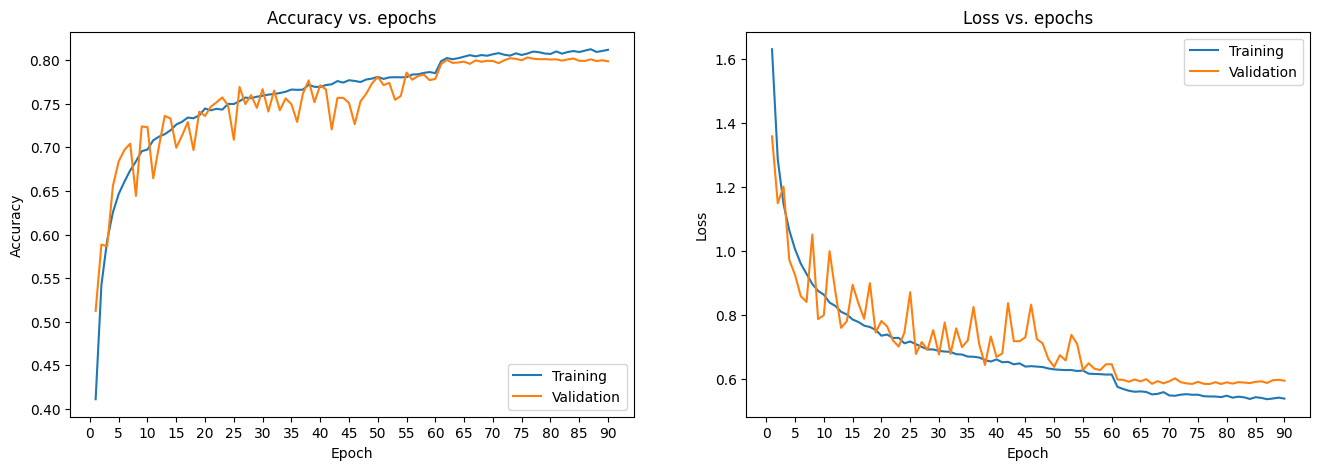

2022-10-02 06:00:35,541: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-10-02 06:00:48,441: INFO: test loss:0.5840
2022-10-02 06:00:48,442: INFO: test accuracy:0.8031
2022-10-02 06:00:48,444: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 06:00:48,446: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 06:00:48,446: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 06:00:48,448: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 06:00:48,449: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-10-02 06:00:49,400: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


313/313 [==============================] - 1s 2ms/step


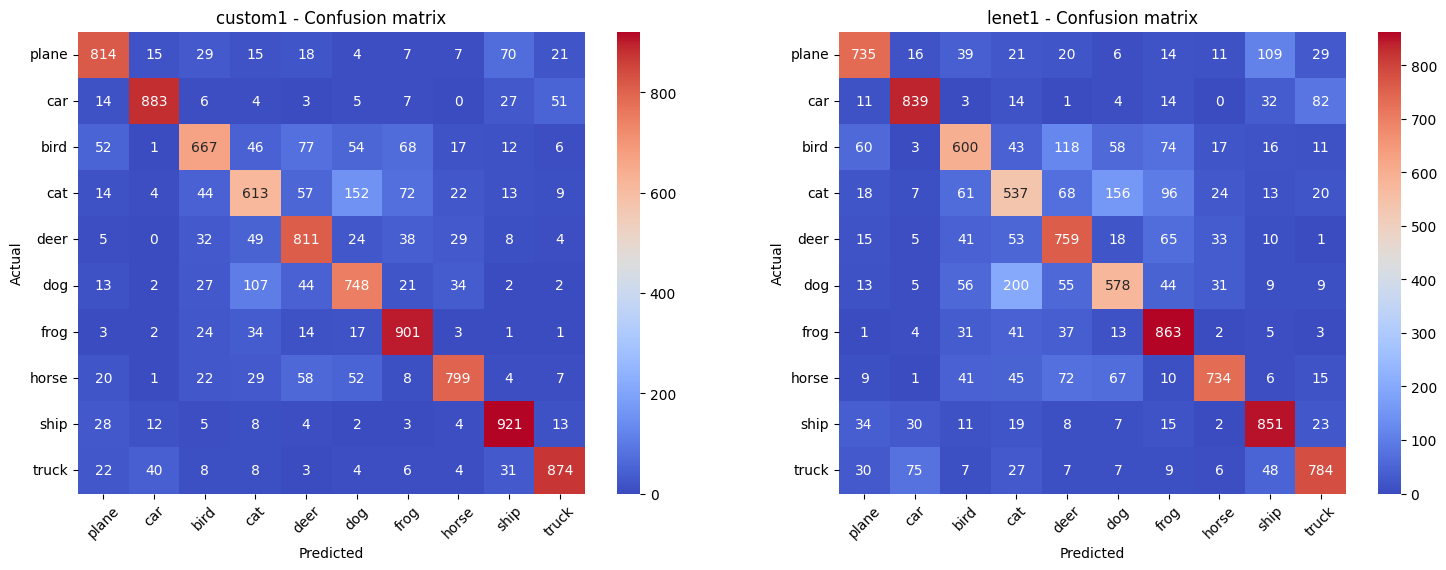

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_5000.ipynb          73738       815.4   
2     lenet1  cifar10_0816_cnt_5000.ipynb          83170       730.8   
3       mlp1  cifar10_0816_cnt_5000.ipynb         394634       378.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-10-02 06:00      0.3144     0.5840          0.8937         0.8031   
2  2022-10-02 05:46      0.4656     0.8065          0.8413         0.7280   
3  2022-10-02 05:34      1.5657     1.6460          0.4377         0.4044   

   train_auc  test_auc  
1     0.9937    0.9790  
2     0.9870    0.9608  
3     0.8543    0.8349

In [42]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [43]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[102  82  71]
 [101  81  70]
 [103  83  72]
 [110  90  79]
 [100  81  70]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.40000004 0.32156864 0.2784314 ]
 [0.39607847 0.31764707 0.27450982]
 [0.4039216  0.3254902  0.28235295]
 [0.43137258 0.3529412  0.30980393]
 [0.3921569  0.31764707 0.27450982]], shape=(5, 3), dtype=float32)


In [44]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-10-02 06:00:53,185: INFO: model_params.vgg8.dropout=0.1
2022-10-02 06:00:53,360: INFO: learning_rate=0.001
2022-10-02 06:00:53,362: INFO: model_params.vgg8.clip_value=None
2022-10-02 06:00:53,368: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-10-02 06:00:53,520: INFO: model_params.vgg8.epochs=90
2022-10-02 06:00:53,521: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8, monitor=val_accuracy)
2022-10-02 06:00:53,522: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-10-02 06:00:53,522: INFO: use LearningRateScheduler()
2022-10-02 06:00:53,523: INFO: steps_per_epoch=1562
2022-10-02 06:00:53,524: INFO: start training
2022-10-02 06:00:53,524: INFO: use_class_weight=False


Epoch 1/90
1559/1562 [============================>.] - ETA: 0s - loss: 1.4604 - accuracy: 0.4708

2022-10-02 06:01:14,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:01:15,437: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 22s 13ms/step - loss: 1.4603 - accuracy: 0.4709 - val_loss: 1.3490 - val_accuracy: 0.5351 - lr: 0.0010
Epoch 2/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.9935 - accuracy: 0.6441

2022-10-02 06:01:34,394: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:01:35,502: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.9936 - accuracy: 0.6441 - val_loss: 1.1629 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 3/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.7177

2022-10-02 06:01:54,794: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:01:55,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.8055 - accuracy: 0.7175 - val_loss: 0.7351 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 4/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.6802 - accuracy: 0.7632

2022-10-02 06:02:14,971: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:02:16,082: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.6804 - accuracy: 0.7631 - val_loss: 0.6968 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 5/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5764 - accuracy: 0.7995 - val_loss: 0.8285 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 6/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.8274

2022-10-02 06:02:52,202: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:02:53,317: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.4959 - accuracy: 0.8275 - val_loss: 0.6922 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 7/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.4229 - accuracy: 0.8537

2022-10-02 06:03:12,257: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:03:13,647: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.4229 - accuracy: 0.8537 - val_loss: 0.5835 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 8/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.3626 - accuracy: 0.8732 - val_loss: 0.6980 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 9/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.3067 - accuracy: 0.8907 - val_loss: 0.6781 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2636 - accuracy: 0.9074 - val_loss: 0.7886 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 11/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2218 - accuracy: 0.9235 - val_loss: 0.6991 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 12/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2005 - accuracy: 0.9295 - val_loss: 0.8514 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 13/90
1562/1562 [==============================]

2022-10-02 06:05:45,430: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:05:46,532: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1267 - accuracy: 0.9569 - val_loss: 0.8289 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 17/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9596

2022-10-02 06:06:05,566: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:06:07,023: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1172 - accuracy: 0.9596 - val_loss: 0.8578 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 18/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1040 - accuracy: 0.9649 - val_loss: 0.9251 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 19/90
1557/1562 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9662

2022-10-02 06:06:42,669: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:06:43,786: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1000 - accuracy: 0.9662 - val_loss: 0.7846 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 20/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9692

2022-10-02 06:07:02,770: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:07:04,203: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0912 - accuracy: 0.9692 - val_loss: 0.7315 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 21/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0854 - accuracy: 0.9707 - val_loss: 0.9293 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 22/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9708

2022-10-02 06:07:39,688: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:07:40,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0856 - accuracy: 0.9707 - val_loss: 0.7954 - val_accuracy: 0.8452 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
1557/1562 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9859

2022-10-02 06:07:59,810: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:08:00,922: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0421 - accuracy: 0.9859 - val_loss: 0.6667 - val_accuracy: 0.8715 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9908

2022-10-02 06:08:20,221: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:08:21,335: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0277 - accuracy: 0.9908 - val_loss: 0.6720 - val_accuracy: 0.8722 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9919

2022-10-02 06:08:40,188: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:08:41,431: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.7117 - val_accuracy: 0.8734 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.7384 - val_accuracy: 0.8700 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.7866 - val_accuracy: 0.8672 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.7642 - val_accuracy: 0.8721 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0183 - accuracy

2022-10-02 06:12:19,509: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:12:20,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.8231 - val_accuracy: 0.8771 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9976

2022-10-02 06:12:39,633: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:12:40,730: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0068 - accuracy: 0.9976 - val_loss: 0.8145 - val_accuracy: 0.8773 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/90
1558/1562 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9981

2022-10-02 06:13:00,037: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:13:01,140: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.8423 - val_accuracy: 0.8792 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

2022-10-02 06:13:20,241: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:13:21,345: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.8372 - val_accuracy: 0.8795 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9985

2022-10-02 06:13:40,571: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:13:41,673: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.8468 - val_accuracy: 0.8796 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.8608 - val_accuracy: 0.8779 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.8670 - val_accuracy: 0.8782 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
1557/1562 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985

2022-10-02 06:14:33,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:14:34,615: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.8432 - val_accuracy: 0.8798 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.8465 - val_accuracy: 0.8789 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
1561/1562 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986

2022-10-02 06:15:10,489: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


2022-10-02 06:15:11,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.8443 - val_accuracy: 0.8826 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.8917 - val_accuracy: 0.8795 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.8910 - val_accuracy: 0.8796 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.8917 - val_accuracy: 0.8793 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0039 - accuracy: 0.9988 - v

Epoch 00085: Still keep learning rate 1e-05 instead of 0.0001
Epoch 85/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.8228 - val_accuracy: 0.8799 - lr: 1.0000e-05
Epoch 00086: Still keep learning rate 1e-05 instead of 0.0001
Epoch 86/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.8225 - val_accuracy: 0.8804 - lr: 1.0000e-05
Epoch 00087: Still keep learning rate 1e-05 instead of 0.0001
Epoch 87/90
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.8224 - val_accuracy: 0.8804 - lr: 1.0000e-05
Epoch 00088: Still keep learning rate 1e-05 instead of 0.0001
Epoch 88/90
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.8248 - val_accuracy: 0.8810 - lr: 1.0000e-05
Epoch 00089: Still keep learning rate 1e-05 instead of 0.0001
Epoch 89/90
1562/1562 [===========

2022-10-02 06:27:01,366: INFO: finish training [elapsed time: 1567.84 seconds]


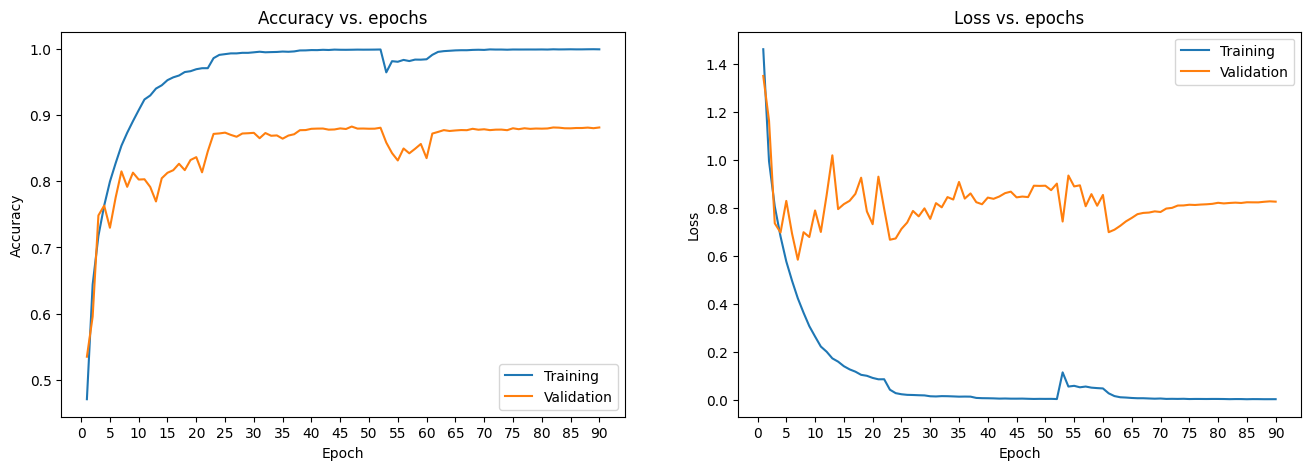

2022-10-02 06:27:01,802: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-10-02 06:27:19,613: INFO: test loss:0.8443
2022-10-02 06:27:19,614: INFO: test accuracy:0.8826
2022-10-02 06:27:19,616: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json


----------------------------------------save model results and generator----------------------------------------


2022-10-02 06:27:19,618: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 06:27:19,618: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 06:27:19,620: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 06:27:19,620: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/custom1


----------------------------------------confusion matrix----------------------------------------


2022-10-02 06:27:21,012: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


313/313 [==============================] - 1s 2ms/step


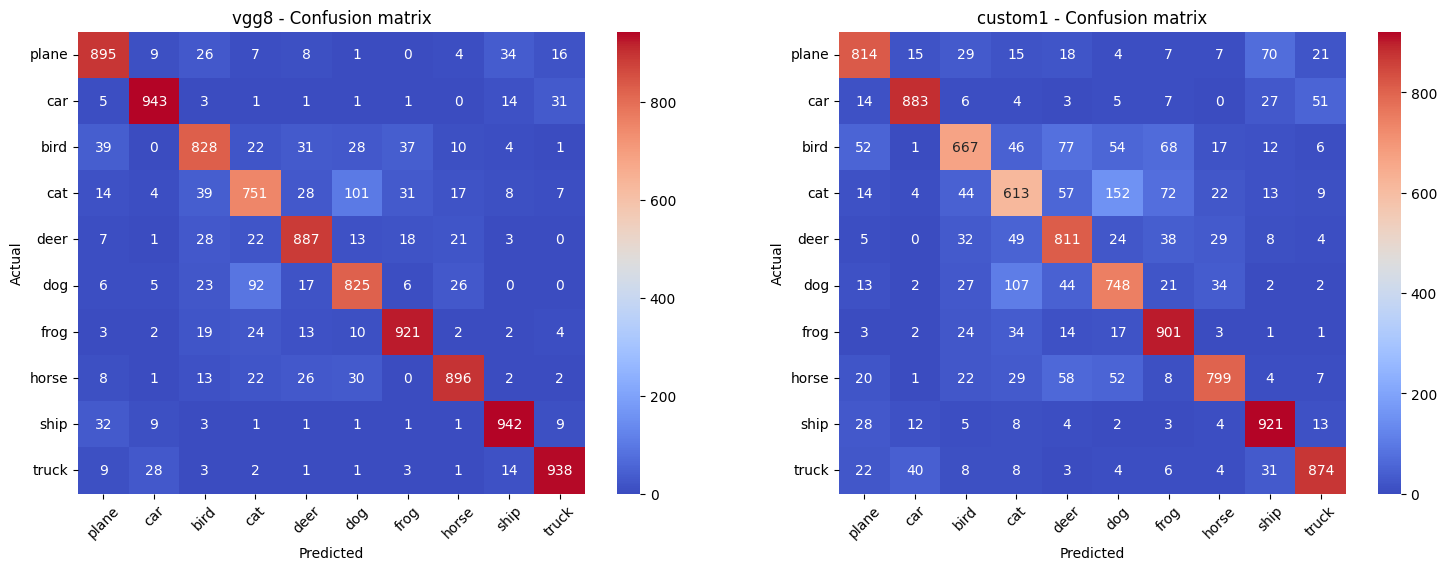

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_5000.ipynb        1672906      1567.8   
2    custom1  cifar10_0816_cnt_5000.ipynb          73738       815.4   
3     lenet1  cifar10_0816_cnt_5000.ipynb          83170       730.8   
4       mlp1  cifar10_0816_cnt_5000.ipynb         394634       378.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-10-02 06:27      0.0006     0.8443          0.9999         0.8826   
2  2022-10-02 06:00      0.3144     0.5840          0.8937         0.8031   
3  2022-10-02 05:46      0.4656     0.8065          0.8413         0.7280   
4  2022-10-02 05:34      1.5657     1.6460          0.4377         0.4044   

   train_auc  test_auc  
1     1.0000    0.9901  
2     0.9937    0.9790  
3     0.9870    0.9608  
4     0.8543    0.8349

In [45]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-10-02 06:27:25,355: INFO: learning_rate=0.001
2022-10-02 06:27:25,356: INFO: model_params.resnet_v1_20.clip_value=None
2022-10-02 06:27:25,363: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-10-02 06:27:25,513: INFO: model_params.resnet_v1_20.epochs=90
2022-10-02 06:27:25,514: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20, monitor=val_accuracy)
2022-10-02 06:27:25,515: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-10-02 06:27:25,516: INFO: use LearningRateScheduler()
2022-10-02 06:27:25,516: INFO: steps_per_epoch=1562
2022-10-02 06:27:25,517: INFO: start training
2022-10-02 06:27:25,518: INFO: use_class_weight=False


Epoch 1/90
1562/1562 [==============================] - ETA: 0s - loss: 1.5091 - accuracy: 0.5075

2022-10-02 06:28:06,213: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:28:09,248: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 44s 26ms/step - loss: 1.5091 - accuracy: 0.5075 - val_loss: 1.3920 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 2/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.0896 - accuracy: 0.6705

2022-10-02 06:28:46,267: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:28:49,544: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 1.0896 - accuracy: 0.6704 - val_loss: 1.1503 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 3/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.9034 - accuracy: 0.7411

2022-10-02 06:29:27,648: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:29:30,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 41s 26ms/step - loss: 0.9034 - accuracy: 0.7410 - val_loss: 1.1184 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 4/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.7918 - accuracy: 0.7834

2022-10-02 06:30:08,992: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:30:11,993: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 41s 26ms/step - loss: 0.7918 - accuracy: 0.7833 - val_loss: 1.0443 - val_accuracy: 0.7093 - lr: 0.0010
Epoch 5/90
1562/1562 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.8173

2022-10-02 06:30:49,348: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:30:52,341: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.7128 - accuracy: 0.8173 - val_loss: 0.9792 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 6/90
1559/1562 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.8419

2022-10-02 06:31:29,478: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:31:32,744: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.6524 - accuracy: 0.8420 - val_loss: 0.9846 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 7/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6027 - accuracy: 0.8622 - val_loss: 1.1511 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 8/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5634 - accuracy: 0.8790 - val_loss: 1.1491 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 9/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5372 - accuracy: 0.8910 - val_loss: 1.1466 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5154 - accuracy: 0.9009 - val_loss: 1.3563 - val_accuracy: 0.7142 - lr: 0.0010
Epoch 11/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5044 - accuracy: 0.9092 - val_loss: 1.2314 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 12/90
1562/1562 [==============================] 

2022-10-02 06:39:06,103: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:39:10,091: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 41s 26ms/step - loss: 0.3696 - accuracy: 0.9759 - val_loss: 1.1342 - val_accuracy: 0.8090 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/90
1562/1562 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9962

2022-10-02 06:39:46,968: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:39:50,028: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 25ms/step - loss: 0.3035 - accuracy: 0.9962 - val_loss: 1.2200 - val_accuracy: 0.8098 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2674 - accuracy: 0.9997 - val_loss: 1.2533 - val_accuracy: 0.8077 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2809 - accuracy: 0.9871 - val_loss: 1.3299 - val_accuracy: 0.7977 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2553 - accuracy: 0.9935 - val_loss: 1.2719 - val_accuracy: 0.8086 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2465 - accuracy

2022-10-02 06:46:52,383: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:46:55,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 25ms/step - loss: 0.1878 - accuracy: 0.9971 - val_loss: 1.2781 - val_accuracy: 0.8151 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/90
1562/1562 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9999

2022-10-02 06:47:32,302: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:47:35,319: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.1756 - accuracy: 0.9999 - val_loss: 1.2858 - val_accuracy: 0.8176 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/90
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1675 - accuracy: 1.0000 - val_loss: 1.2976 - val_accuracy: 0.8172 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
1562/1562 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 1.0000

2022-10-02 06:48:41,132: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:48:44,144: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.1532 - accuracy: 1.0000 - val_loss: 1.3043 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1282 - accuracy: 1.0000 - val_loss: 1.3190 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/90
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1186 - accuracy: 0.9965 - val_loss: 1.3389 - val_accuracy: 0.8097 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1071 - accuracy: 0.9999 - val_loss: 1.3090 - val_accuracy: 0.8186 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
1562/1562 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 1.0000

2022-10-02 06:50:51,284: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:50:54,551: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 41s 26ms/step - loss: 0.1029 - accuracy: 1.0000 - val_loss: 1.3149 - val_accuracy: 0.8202 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
1560/1562 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 1.0000

2022-10-02 06:51:31,821: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 06:51:34,934: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.0967 - accuracy: 1.0000 - val_loss: 1.3268 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0850 - accuracy: 1.0000 - val_loss: 1.3383 - val_accuracy: 0.8191 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0945 - accuracy: 0.9925 - val_loss: 1.3144 - val_accuracy: 0.8081 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0755 - accuracy: 0.9987 - val_loss: 1.3413 - val_accuracy: 0.8127 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0713 - accuracy: 0.9998 - v

2022-10-02 07:00:09,196: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


2022-10-02 07:00:12,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 26ms/step - loss: 0.3308 - accuracy: 0.9693 - val_loss: 0.9092 - val_accuracy: 0.8356 - lr: 1.0000e-04
Epoch 62/90
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2719 - accuracy: 0.9923 - val_loss: 0.9529 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 63/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2464 - accuracy: 0.9986 - val_loss: 1.0104 - val_accuracy: 0.8350 - lr: 1.0000e-04
Epoch 64/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2277 - accuracy: 0.9998 - val_loss: 1.0716 - val_accuracy: 0.8340 - lr: 1.0000e-04
Epoch 65/90
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2072 - accuracy: 1.0000 - val_loss: 1.1195 - val_accuracy: 0.8342 - lr: 1.0000e-04
Epoch 66/90
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 1.1532 - val_accuracy: 0.8338 - lr: 1.0000e-04
Epoch 67/90
1562/1562 [=====

2022-10-02 07:14:34,084: INFO: finish training [elapsed time: 2828.57 seconds]


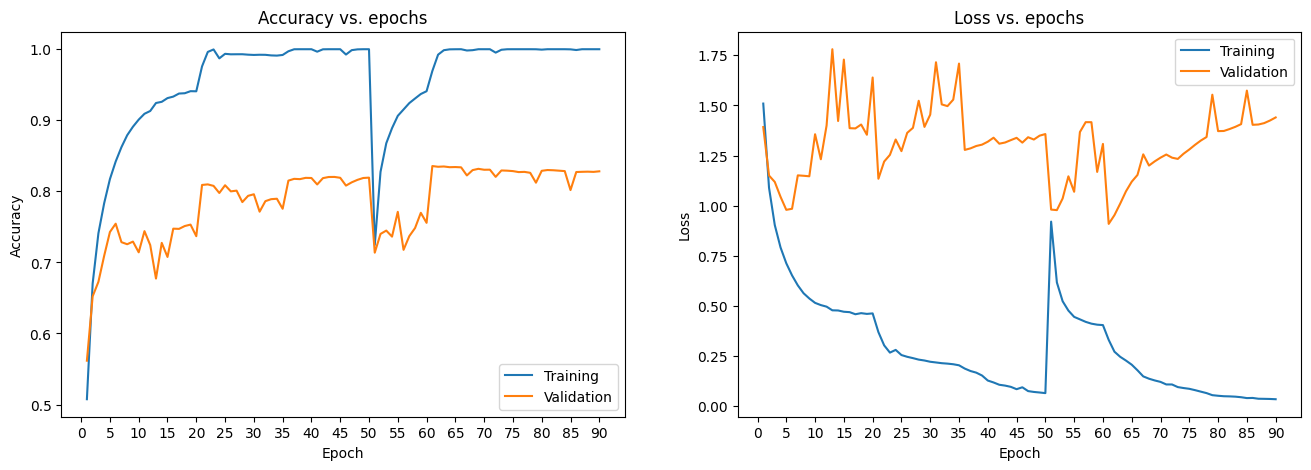

2022-10-02 07:14:34,663: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-10-02 07:15:08,815: INFO: test loss:0.9092
2022-10-02 07:15:08,815: INFO: test accuracy:0.8356
2022-10-02 07:15:08,819: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 07:15:08,821: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 07:15:08,822: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 07:15:08,823: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 07:15:08,823: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-10-02 07:15:10,445: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


313/313 [==============================] - 1s 3ms/step


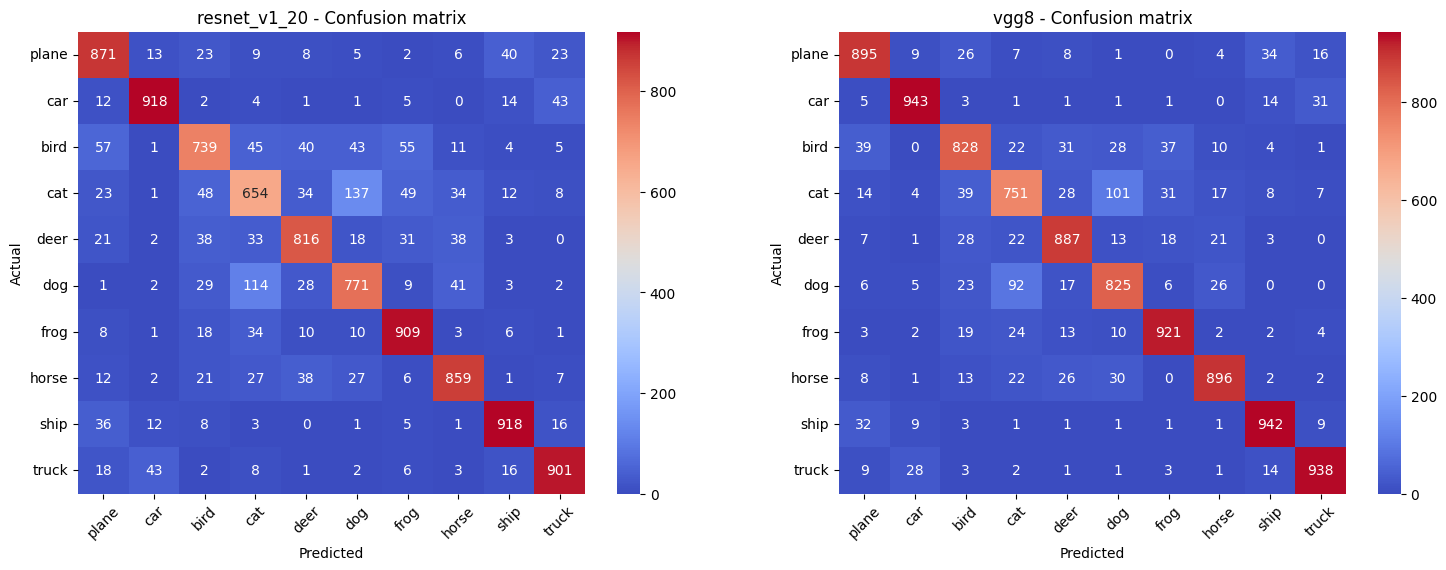

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_5000.ipynb        1672906      1567.8   
2  resnet_v1_20  cifar10_0816_cnt_5000.ipynb         273066      2828.6   
3       custom1  cifar10_0816_cnt_5000.ipynb          73738       815.4   
4        lenet1  cifar10_0816_cnt_5000.ipynb          83170       730.8   
5          mlp1  cifar10_0816_cnt_5000.ipynb         394634       378.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-10-02 06:27      0.0006     0.8443          0.9999         0.8826   
2  2022-10-02 07:15      0.2900     0.9092          0.9851         0.8356   
3  2022-10-02 06:00      0.3144     0.5840          0.8937         0.8031   
4  2022-10-02 05:46      0.4656     0.8065          0.8413         0.7280   
5  2022-10-02 05:34      1.5657     1.6460          0.4377         0.4044   

   train_auc  test_auc  
1     1.0000    0.9901  
2     0.9998    0.9837  
3     0.9937    0.9790  
4     0.9870    0.9608  
5     0.8543    0.8349

In [46]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [47]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [48]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [49]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


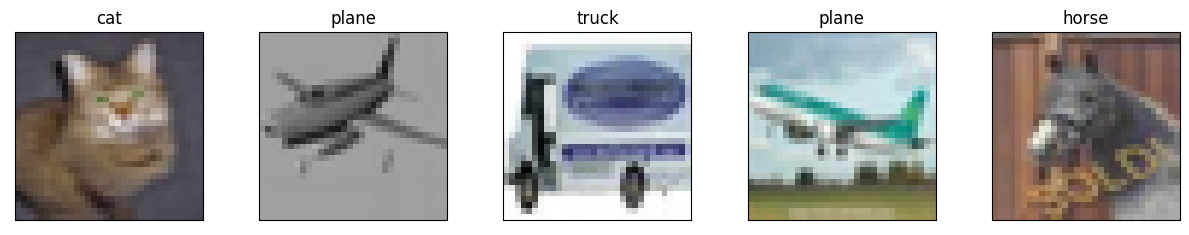

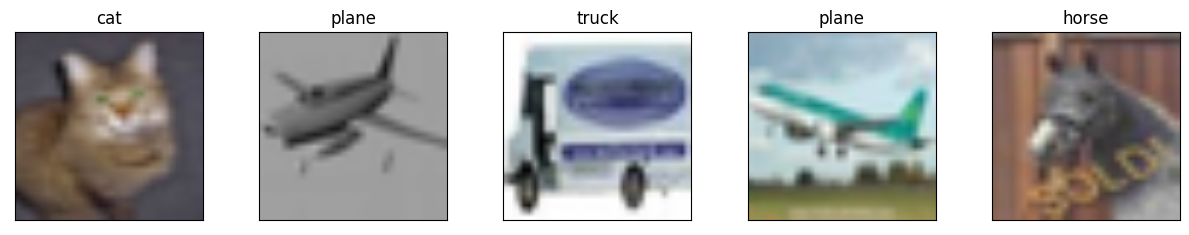

In [50]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [51]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 20, 20, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

In [52]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [53]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-10-02 07:15:23,114: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-10-02 07:15:23,115: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-10-02 07:15:23,124: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10

2022-10-02 07:15:32,146: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-10-02 07:15:32,148: INFO: steps_per_epoch=1562
2022-10-02 07:15:32,149: INFO: start training
2022-10-02 07:15:32,149: INFO: use_class_weight=False


Epoch 1/10
1561/1562 [============================>.] - ETA: 0s - loss: 1.0869 - accuracy: 0.6380

2022-10-02 07:16:31,377: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:16:36,265: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 65s 40ms/step - loss: 1.0868 - accuracy: 0.6380 - val_loss: 0.5807 - val_accuracy: 0.8086
Epoch 2/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.8028

2022-10-02 07:17:32,962: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:17:38,048: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.5825 - accuracy: 0.8027 - val_loss: 0.4880 - val_accuracy: 0.8344
Epoch 3/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.8254

2022-10-02 07:18:35,387: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:18:40,475: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.5092 - accuracy: 0.8254 - val_loss: 0.4540 - val_accuracy: 0.8440
Epoch 4/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4731 - accuracy: 0.8387

2022-10-02 07:19:37,839: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:19:43,158: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 63s 40ms/step - loss: 0.4732 - accuracy: 0.8386 - val_loss: 0.4337 - val_accuracy: 0.8505
Epoch 5/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4483 - accuracy: 0.8470

2022-10-02 07:20:40,267: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:20:45,003: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.4485 - accuracy: 0.8470 - val_loss: 0.4217 - val_accuracy: 0.8550
Epoch 6/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4318 - accuracy: 0.8524

2022-10-02 07:21:42,618: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:21:47,573: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 63s 40ms/step - loss: 0.4320 - accuracy: 0.8524 - val_loss: 0.4125 - val_accuracy: 0.8580
Epoch 7/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.8557

2022-10-02 07:22:45,048: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:22:49,764: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.4192 - accuracy: 0.8557 - val_loss: 0.4065 - val_accuracy: 0.8600
Epoch 8/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4113 - accuracy: 0.8588

2022-10-02 07:23:46,958: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:23:52,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.4114 - accuracy: 0.8587 - val_loss: 0.4017 - val_accuracy: 0.8607
Epoch 9/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8633

2022-10-02 07:24:49,184: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:24:53,968: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.4026 - accuracy: 0.8633 - val_loss: 0.3985 - val_accuracy: 0.8643
Epoch 10/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.3942 - accuracy: 0.8642

2022-10-02 07:25:51,199: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:25:55,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 62s 40ms/step - loss: 0.3943 - accuracy: 0.8642 - val_loss: 0.3945 - val_accuracy: 0.8650


2022-10-02 07:25:56,610: INFO: finish training [elapsed time: 624.46 seconds]


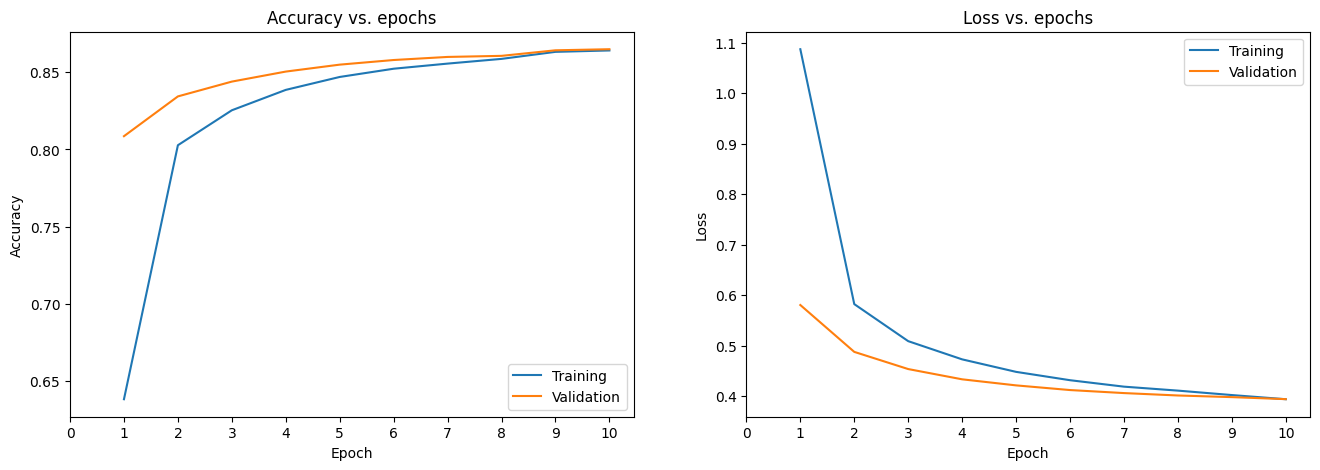

In [54]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [55]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-10-02 07:25:57,174: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-10-02 07:25:57,174: INFO: steps_per_epoch=1562
2022-10-02 07:25:57,175: INFO: start training
2022-10-02 07:25:57,176: INFO: use_class_weight=False


Epoch 1/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.3468 - accuracy: 0.8813

2022-10-02 07:27:19,885: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:27:25,280: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 89s 53ms/step - loss: 0.3469 - accuracy: 0.8813 - val_loss: 0.3116 - val_accuracy: 0.8941
Epoch 2/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.9109

2022-10-02 07:28:42,127: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:28:47,559: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.2617 - accuracy: 0.9109 - val_loss: 0.2810 - val_accuracy: 0.9060
Epoch 3/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9280

2022-10-02 07:30:04,702: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:30:09,749: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.2086 - accuracy: 0.9280 - val_loss: 0.2709 - val_accuracy: 0.9106
Epoch 4/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9424

2022-10-02 07:31:26,901: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:31:32,279: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 83s 53ms/step - loss: 0.1681 - accuracy: 0.9424 - val_loss: 0.2674 - val_accuracy: 0.9134
Epoch 5/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9537

2022-10-02 07:32:49,407: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:32:54,489: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.1374 - accuracy: 0.9537 - val_loss: 0.2661 - val_accuracy: 0.9136
Epoch 6/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9632

2022-10-02 07:34:11,751: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:34:16,777: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.1105 - accuracy: 0.9632 - val_loss: 0.2759 - val_accuracy: 0.9177
Epoch 7/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9707

2022-10-02 07:35:33,968: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:35:39,376: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.0903 - accuracy: 0.9707 - val_loss: 0.2810 - val_accuracy: 0.9179
Epoch 8/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9775

2022-10-02 07:36:56,356: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:37:01,454: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.0710 - accuracy: 0.9775 - val_loss: 0.2943 - val_accuracy: 0.9181
Epoch 9/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9830

2022-10-02 07:38:18,736: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:38:23,769: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.0553 - accuracy: 0.9830 - val_loss: 0.2981 - val_accuracy: 0.9220
Epoch 10/15
1562/1562 [==============================] - 59s 38ms/step - loss: 0.0433 - accuracy: 0.9875 - val_loss: 0.3380 - val_accuracy: 0.9156
Epoch 11/15
1562/1562 [==============================] - 59s 38ms/step - loss: 0.0333 - accuracy: 0.9906 - val_loss: 0.3357 - val_accuracy: 0.9204
Epoch 12/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9935

2022-10-02 07:41:39,732: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


2022-10-02 07:41:44,707: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 82s 53ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.3524 - val_accuracy: 0.9222
Epoch 13/15
1562/1562 [==============================] - 59s 38ms/step - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.3704 - val_accuracy: 0.9204
Epoch 14/15
1562/1562 [==============================] - 60s 38ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.3942 - val_accuracy: 0.9211
Epoch 15/15
1562/1562 [==============================] - 60s 38ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.3856 - val_accuracy: 0.9211


2022-10-02 07:44:43,959: INFO: finish training [elapsed time: 1126.78 seconds]


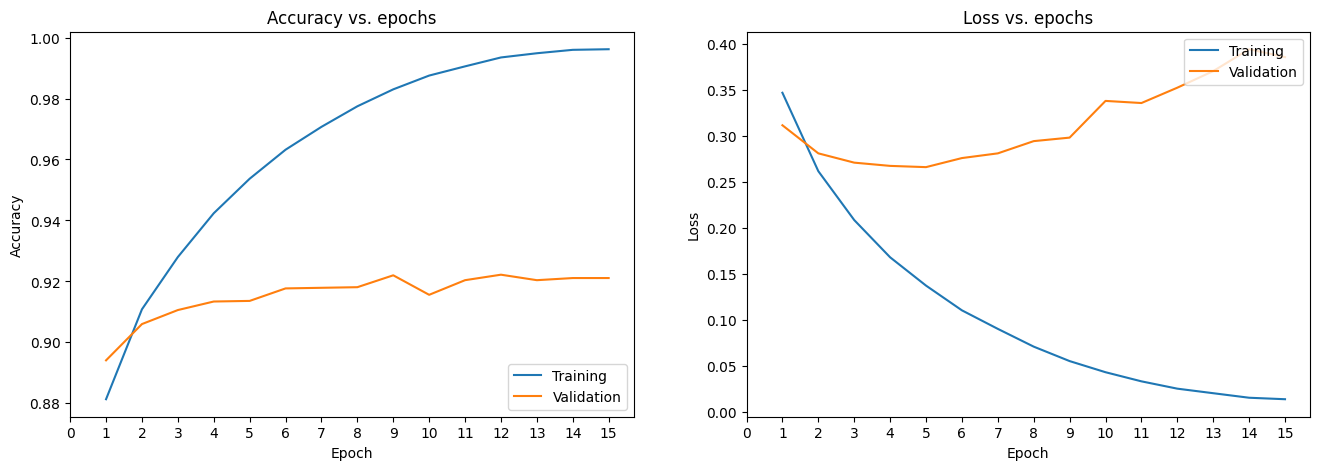

2022-10-02 07:44:44,380: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 6s 20ms/step


2022-10-02 07:46:18,282: INFO: test loss:0.3524
2022-10-02 07:46:18,282: INFO: test accuracy:0.9222
2022-10-02 07:46:18,286: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 07:46:18,288: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/results.json
2022-10-02 07:46:18,288: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 07:46:18,290: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 07:46:18,290: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-10-02 07:46:19,869: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator


313/313 [==============================] - 1s 3ms/step


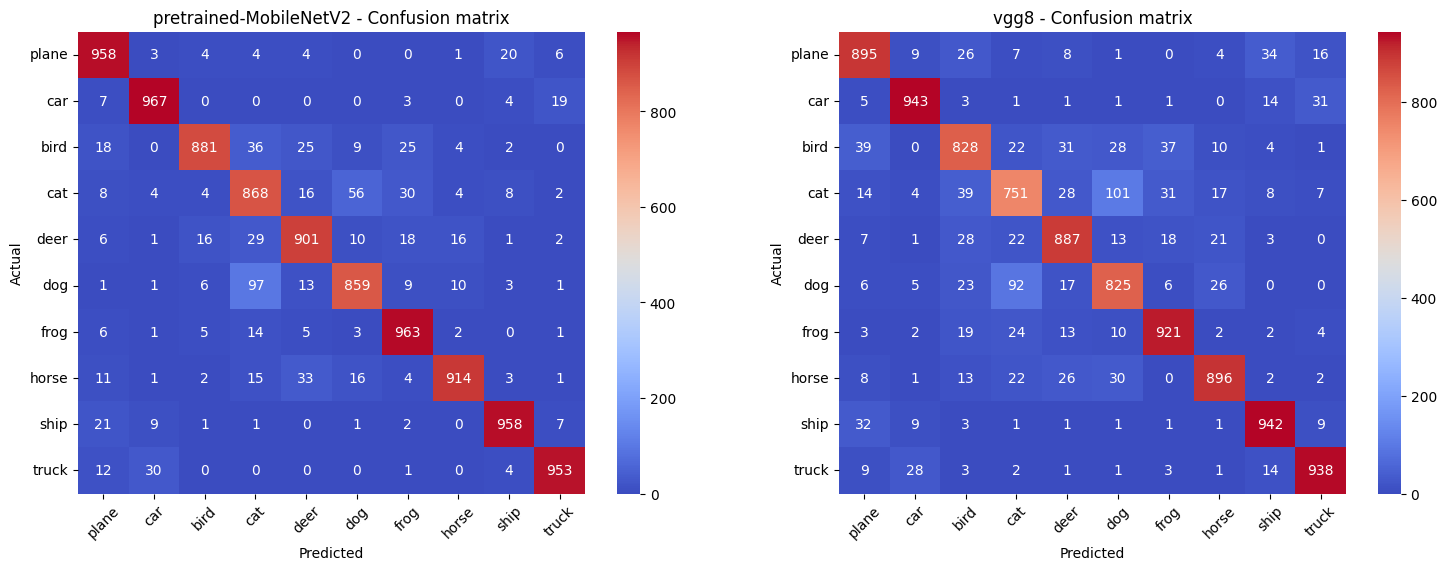

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_5000.ipynb        1874250   
2                    vgg8  cifar10_0816_cnt_5000.ipynb        1672906   
3            resnet_v1_20  cifar10_0816_cnt_5000.ipynb         273066   
4                 custom1  cifar10_0816_cnt_5000.ipynb          73738   
5                  lenet1  cifar10_0816_cnt_5000.ipynb          83170   
6                    mlp1  cifar10_0816_cnt_5000.ipynb         394634   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1      1126.8  2022-10-02 07:46      0.0249     0.3524          0.9918   
2      1567.8  2022-10-02 06:27      0.0006     0.8443          0.9999   
3      2828.6  2022-10-02 07:15      0.2900     0.9092          0.9851   
4       815.4  2022-10-02 06:00      0.3144     0.5840          0.8937   
5       730.8  2022-10-02 05:46      0.4656     0.8065          0.8413   
6       378.4  2022-10-02 05:34      1.5657     1.6460          0.4377   

   test_accuracy  train_auc  test_auc  
1         0.9222     1.0000    0.9960  
2         0.8826     1.0000    0.9901  
3         0.8356     0.9998    0.9837  
4         0.8031     0.9937    0.9790  
5         0.7280     0.9870    0.9608  
6         0.4044     0.8543    0.8349

In [56]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [57]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(20)

2022-10-02 07:46:29,454: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-10-02 07:46:29,484: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-10-02 07:46:29,502: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-10-02 07:46:29,504: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-10-02 07:46:29,514: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-10-02 07:46:29,515: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name                       program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug_1.ipynb        1874250   
2   pretrained-MobileNetV2        cifar10_0816_cnt_5000.ipynb        1874250   
3   pretrained-MobileNetV2    cifar10_0816_cnt_5000_aug.ipynb        1874250   
4   pretrained-MobileNetV2        cifar10_0816_cnt_2000.ipynb        1874250   
5   pretrained-MobileNetV2        cifar10_0816_cnt_1000.ipynb        1874250   
6                     vgg8        cifar10_0816_cnt_5000.ipynb        1672906   
7   pretrained-MobileNetV2         cifar10_0816_cnt_500.ipynb        1874250   
8   pretrained-MobileNetV2         cifar10_0816_cnt_200.ipynb        1874250   
9             resnet_v1_20        cifar10_0816_cnt_5000.ipynb         273066   
10                    vgg8        cifar10_0816_cnt_2000.ipynb        1672906   
11  pretrained-MobileNetV2         cifar10_0816_cnt_100.ipynb        1874250   
12                 custom1        cifar10_0816_cnt_5000.ipynb          73738   
13                    vgg8        cifar10_0816_cnt_1000.ipynb        1672906   
14  pretrained-MobileNetV2          cifar10_0816_cnt_50.ipynb        1874250   
15                 custom1        cifar10_0816_cnt_2000.ipynb          73738   
16                  lenet1        cifar10_0816_cnt_5000.ipynb          83170   
17            resnet_v1_20        cifar10_0816_cnt_2000.ipynb         273066   
18                    vgg8         cifar10_0816_cnt_500.ipynb        1672906   
19                 custom1        cifar10_0816_cnt_1000.ipynb          73738   
20                  lenet1        cifar10_0816_cnt_2000.ipynb          83170   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1       1414.6  2022-08-17 05:31      0.1048     0.2324          0.9630   
2       1126.8  2022-10-02 07:46      0.0249     0.3524          0.9918   
3       1517.0  2022-08-17 06:29      0.1540     0.2510          0.9470   
4        762.3  2022-08-16 11:22      0.0112     0.4282          0.9976   
5        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
6       1567.8  2022-10-02 06:27      0.0006     0.8443          0.9999   
7        487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
8        390.8  2022-08-18 20:13      0.0187     0.5293          0.9995   
9       2828.6  2022-10-02 07:15      0.2900     0.9092          0.9851   
10      1019.2  2022-08-16 10:31      0.0003     1.2263          1.0000   
11       421.7  2022-08-18 20:13      0.0355     0.6070          0.9980   
12       815.4  2022-10-02 06:00      0.3144     0.5840          0.8937   
13       435.9  2022-08-16 08:46      0.0137     1.3588          0.9992   
14       392.7  2022-08-18 19:51      0.0873     0.7405          0.9820   
15       447.3  2022-08-16 10:14      0.2368     0.8096          0.9258   
16       730.8  2022-10-02 05:46      0.4656     0.8065          0.8413   
17      1657.6  2022-08-16 10:59      0.1711     1.4189          0.9879   
18       497.7  2022-08-16 09:10      0.0072     1.6269          0.9992   
19       246.7  2022-08-16 08:38      0.1393     1.0998          0.9655   
20       343.7  2022-08-16 10:06      0.3276     0.9998          0.8982   

    test_accuracy  train_auc  test_auc  
1          0.9312     0.9992    0.9967  
2          0.9222     1.0000    0.9960  
3          0.9199     0.9982    0.9958  
4          0.9058     1.0000    0.9944  
5          0.8930     1.0000    0.9929  
6          0.8826     1.0000    0.9901  
7          0.8778     1.0000    0.9906  
8          0.8469     0.9999    0.9866  
9          0.8356     0.9998    0.9837  
10         0.8299     1.0000    0.9791  
11         0.8102     1.0000    0.9795  
12         0.8031     0.9937    0.9790  
13         0.7527     1.0000    0.9586  
14         0.7474     0.9987    0.9664  
15         0.7438     0.9967    0.9651  
16         0.7280     0.9870    0.9608  
17         0.7138     0.9999    0.9546  
18         0.7000    

In [58]:
df_results = qtf.classification.DataModelResults(params.data_path).get_top_n(mode='df') 
df_results 

2022-10-02 07:46:29,647: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-10-02 07:46:29,649: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-10-02 07:46:29,650: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-10-02 07:46:29,652: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-10-02 07:46:29,653: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-10-02 07:46:29,654: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name data_name                       program_name  \
1   pretrained-MobileNetV2   cifar10  cifar10_0816_cnt_5000_aug_1.ipynb   
2   pretrained-MobileNetV2   cifar10        cifar10_0816_cnt_5000.ipynb   
3   pretrained-MobileNetV2   cifar10    cifar10_0816_cnt_5000_aug.ipynb   
4   pretrained-MobileNetV2   cifar10        cifar10_0816_cnt_2000.ipynb   
5   pretrained-MobileNetV2   cifar10        cifar10_0816_cnt_1000.ipynb   
6                     vgg8   cifar10        cifar10_0816_cnt_5000.ipynb   
7   pretrained-MobileNetV2   cifar10         cifar10_0816_cnt_500.ipynb   
8   pretrained-MobileNetV2   cifar10         cifar10_0816_cnt_200.ipynb   
9             resnet_v1_20   cifar10        cifar10_0816_cnt_5000.ipynb   
10                    vgg8   cifar10        cifar10_0816_cnt_2000.ipynb   
11  pretrained-MobileNetV2   cifar10         cifar10_0816_cnt_100.ipynb   
12                 custom1   cifar10        cifar10_0816_cnt_5000.ipynb   
13                    vgg8   cifar10        cifar10_0816_cnt_1000.ipynb   
14  pretrained-MobileNetV2   cifar10          cifar10_0816_cnt_50.ipynb   
15                 custom1   cifar10        cifar10_0816_cnt_2000.ipynb   
16                  lenet1   cifar10        cifar10_0816_cnt_5000.ipynb   
17            resnet_v1_20   cifar10        cifar10_0816_cnt_2000.ipynb   
18                    vgg8   cifar10         cifar10_0816_cnt_500.ipynb   
19                 custom1   cifar10        cifar10_0816_cnt_1000.ipynb   
20                  lenet1   cifar10        cifar10_0816_cnt_2000.ipynb   
21            resnet_v1_20   cifar10        cifar10_0816_cnt_1000.ipynb   
22                 custom1   cifar10         cifar10_0816_cnt_500.ipynb   
23                  lenet1   cifar10        cifar10_0816_cnt_1000.ipynb   
24            resnet_v1_20   cifar10         cifar10_0816_cnt_500.ipynb   
25                  lenet1   cifar10         cifar10_0816_cnt_500.ipynb   
26                    vgg8   cifar10          cifar10_0816_cnt_50.ipynb   
27                    mlp1   cifar10        cifar10_0816_cnt_2000.ipynb   
28                    mlp1   cifar10        cifar10_0816_cnt_5000.ipynb   
29                 custom1   cifar10          cifar10_0816_cnt_50.ipynb   
30                    mlp1   cifar10         cifar10_0816_cnt_500.ipynb   
31                    mlp1   cifar10        cifar10_0816_cnt_1000.ipynb   
32                  lenet1   cifar10          cifar10_0816_cnt_50.ipynb   
33                    mlp1   cifar10          cifar10_0816_cnt_50.ipynb   
34            resnet_v1_20   cifar10          cifar10_0816_cnt_50.ipynb   

                                                                                                                  program_path  \
1   /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1   
2         /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000   
3     /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug   
4         /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000   
5         /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000   
6         /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000   
7          /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500   
8          /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200   
9         /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000   
10        /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/

In [59]:
df_results['count'] = [int(program_name.split('.')[0].split('_')[3]) for program_name in  df_results.program_name]
print(len(df_results)) 
columns = ['data_name', 'model_name', 'program_name', 'weight_number', 'train_time', 
           'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy', 'train_auc', 
           'test_auc', 'count']
df_results = df_results[columns]
df_results.head(10) 

34


data_name              model_name                       program_name  \
1    cifar10  pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug_1.ipynb   
2    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_5000.ipynb   
3    cifar10  pretrained-MobileNetV2    cifar10_0816_cnt_5000_aug.ipynb   
4    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_2000.ipynb   
5    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_1000.ipynb   
6    cifar10                    vgg8        cifar10_0816_cnt_5000.ipynb   
7    cifar10  pretrained-MobileNetV2         cifar10_0816_cnt_500.ipynb   
8    cifar10  pretrained-MobileNetV2         cifar10_0816_cnt_200.ipynb   
9    cifar10            resnet_v1_20        cifar10_0816_cnt_5000.ipynb   
10   cifar10                    vgg8        cifar10_0816_cnt_2000.ipynb   

    weight_number  train_time  train_loss  test_loss  train_accuracy  \
1         1874250      1414.6      0.1048     0.2324          0.9630   
2         1874250      1126.8      0.0249     0.3524          0.9918   
3         1874250      1517.0      0.1540     0.2510          0.9470   
4         1874250       762.3      0.0112     0.4282          0.9976   
5         1874250       598.4      0.0212     0.4112          0.9963   
6         1672906      1567.8      0.0006     0.8443          0.9999   
7         1874250       487.0      0.0125     0.4696          0.9992   
8         1874250       390.8      0.0187     0.5293          0.9995   
9          273066      2828.6      0.2900     0.9092          0.9851   
10        1672906      1019.2      0.0003     1.2263          1.0000   

    test_accuracy  train_auc  test_auc  count  
1          0.9312     0.9992    0.9967   5000  
2          0.9222     1.0000    0.9960   5000  
3          0.9199     0.9982    0.9958   5000  
4          0.9058     1.0000    0.9944   2000  
5          0.8930     1.0000    0.9929   1000  
6          0.8826     1.0000    0.9901   5000  
7          0.8778     1.0000    0.9906    500  
8          0.8469     0.9999    0.9866    200  
9          0.8356     0.9998    0.9837   5000  
10         0.8299     1.0000    0.9791   2000

In [60]:
df_results1 = df_results.loc[(df_results.model_name.str.startswith('pretrained'))]
print(len(df_results1)) 
display(df_results1.head(10)) 
df_results1_group = df_results1.groupby('count')
display(df_results1_group.max('test_accuracy'))

9


data_name              model_name                       program_name  \
1    cifar10  pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug_1.ipynb   
2    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_5000.ipynb   
3    cifar10  pretrained-MobileNetV2    cifar10_0816_cnt_5000_aug.ipynb   
4    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_2000.ipynb   
5    cifar10  pretrained-MobileNetV2        cifar10_0816_cnt_1000.ipynb   
7    cifar10  pretrained-MobileNetV2         cifar10_0816_cnt_500.ipynb   
8    cifar10  pretrained-MobileNetV2         cifar10_0816_cnt_200.ipynb   
11   cifar10  pretrained-MobileNetV2         cifar10_0816_cnt_100.ipynb   
14   cifar10  pretrained-MobileNetV2          cifar10_0816_cnt_50.ipynb   

    weight_number  train_time  train_loss  test_loss  train_accuracy  \
1         1874250      1414.6      0.1048     0.2324          0.9630   
2         1874250      1126.8      0.0249     0.3524          0.9918   
3         1874250      1517.0      0.1540     0.2510          0.9470   
4         1874250       762.3      0.0112     0.4282          0.9976   
5         1874250       598.4      0.0212     0.4112          0.9963   
7         1874250       487.0      0.0125     0.4696          0.9992   
8         1874250       390.8      0.0187     0.5293          0.9995   
11        1874250       421.7      0.0355     0.6070          0.9980   
14        1874250       392.7      0.0873     0.7405          0.9820   

    test_accuracy  train_auc  test_auc  count  
1          0.9312     0.9992    0.9967   5000  
2          0.9222     1.0000    0.9960   5000  
3          0.9199     0.9982    0.9958   5000  
4          0.9058     1.0000    0.9944   2000  
5          0.8930     1.0000    0.9929   1000  
7          0.8778     1.0000    0.9906    500  
8          0.8469     0.9999    0.9866    200  
11         0.8102     1.0000    0.9795    100  
14         0.7474     0.9987    0.9664     50

weight_number  train_time  train_loss  test_loss  train_accuracy  \
count                                                                     
50           1874250       392.7      0.0873     0.7405          0.9820   
100          1874250       421.7      0.0355     0.6070          0.9980   
200          1874250       390.8      0.0187     0.5293          0.9995   
500          1874250       487.0      0.0125     0.4696          0.9992   
1000         1874250       598.4      0.0212     0.4112          0.9963   
2000         1874250       762.3      0.0112     0.4282          0.9976   
5000         1874250      1517.0      0.1540     0.3524          0.9918   

       test_accuracy  train_auc  test_auc  
count                                      
50            0.7474     0.9987    0.9664  
100           0.8102     1.0000    0.9795  
200           0.8469     0.9999    0.9866  
500           0.8778     1.0000    0.9906  
1000          0.8930     1.0000    0.9929  
2000          0.9058     1.0000    0.9944  
5000          0.9312     1.0000    0.9967

In [61]:
df_results1 = df_results.loc[(~df_results.model_name.str.startswith('pretrained'))]
print(len(df_results1)) 
df_results1_group = df_results1.groupby('count')



25


In [62]:
display(df_results1_group.max('test_accuracy'))

weight_number  train_time  train_loss  test_loss  train_accuracy  \
count                                                                     
50           1672906       709.6      1.2401     3.1298          0.9740   
500          1672906       872.3      1.3138     1.7759          0.9992   
1000         1672906       863.5      1.5023     2.1340          0.9992   
2000         1672906      1657.6      1.4991     1.6743          1.0000   
5000         1672906      2828.6      1.5657     1.6460          0.9999   

       test_accuracy  train_auc  test_auc  
count                                      
50            0.4185     0.9987    0.8281  
500           0.7000     1.0000    0.9473  
1000          0.7527     1.0000    0.9586  
2000          0.8299     1.0000    0.9791  
5000          0.8826     1.0000    0.9901

In [63]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-10-02 07:46:30,099: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-10-02 07:46:40,782: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-10-02 07:46:40,822: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-10-02 07:46:51,841: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-10-02 07:46:51,867: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
2022-10-02 07:47:04,185: INFO: load

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [64]:
predictors[0].classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 1s 927ms/step


2022-10-02 07:47:29,723: WARNING: 5 out of the last 317 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc634302e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 914ms/step


2022-10-02 07:47:30,708: WARNING: 6 out of the last 318 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc6341515e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


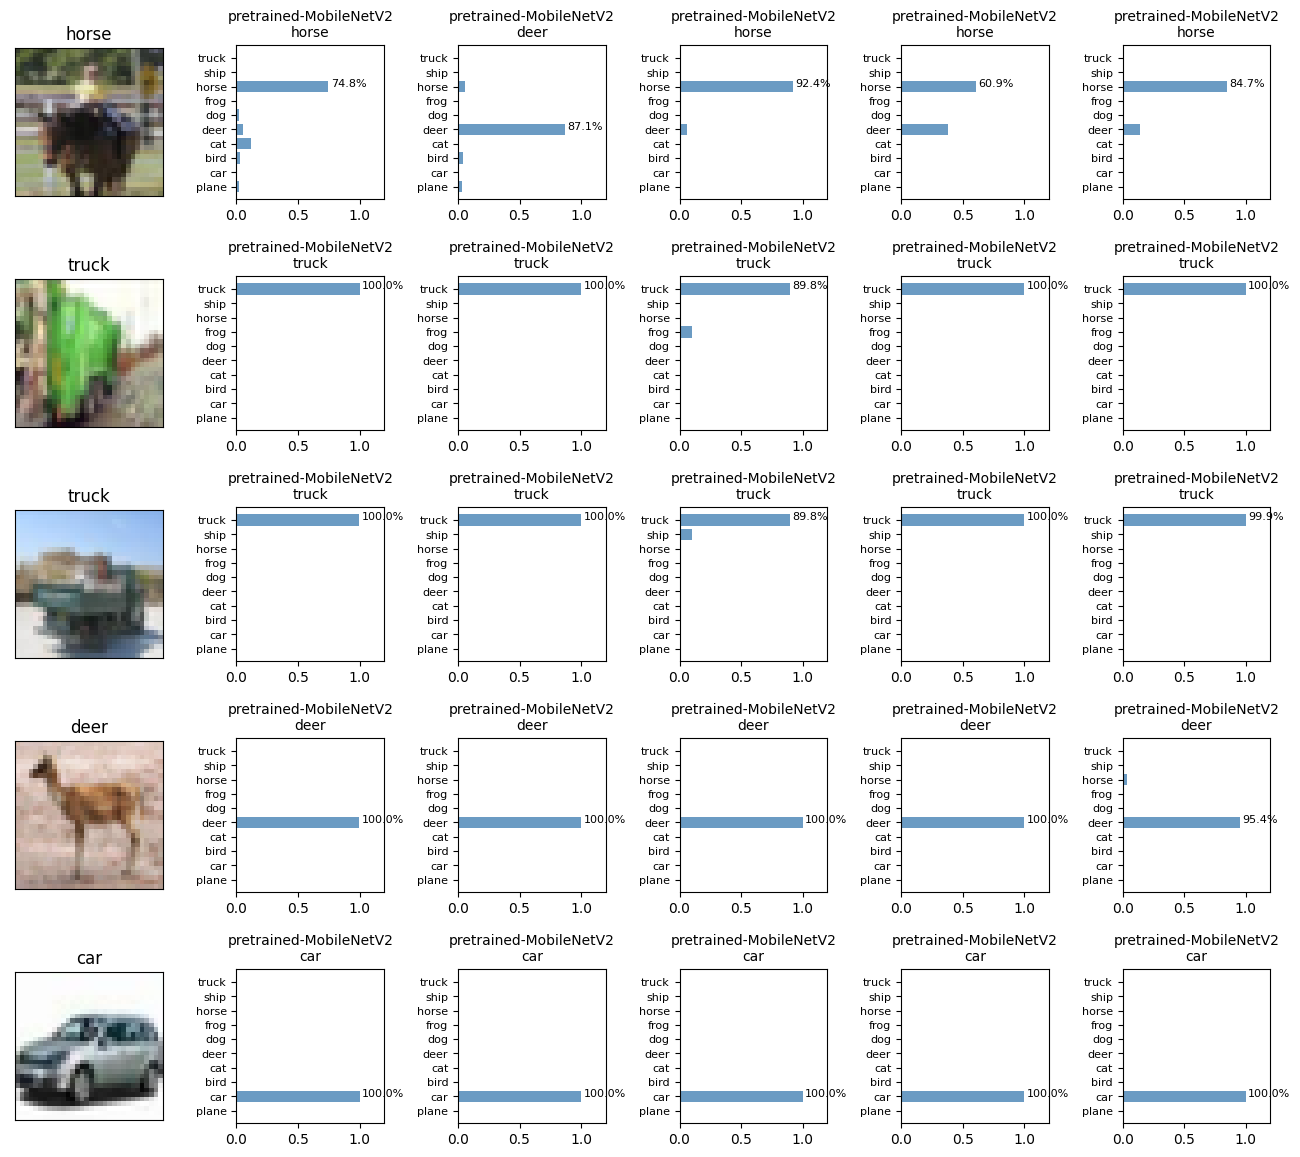

In [65]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                     sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 27ms/step


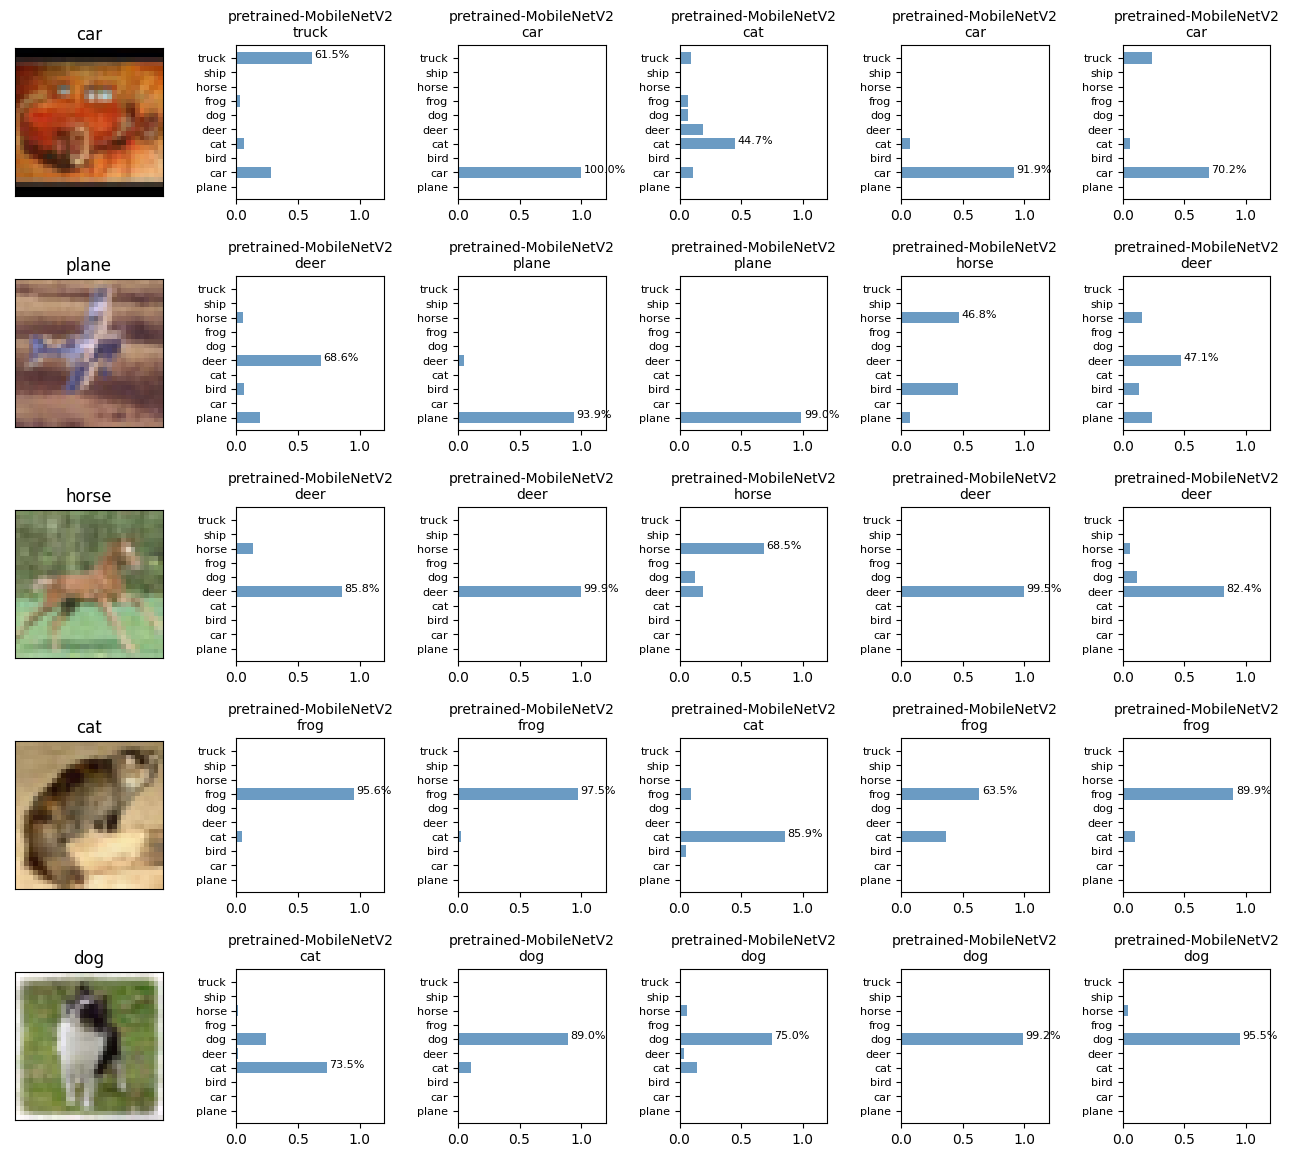

In [66]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [67]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 6s 20ms/step
(10000, 10)


In [68]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 6s 20ms/step


precision  recall        f1
plane   0.910462   0.966  0.937409
car     0.978659   0.963  0.970766
bird    0.940268   0.913  0.926433
cat     0.881799   0.843  0.861963
deer    0.892823   0.933  0.912469
dog     0.929806   0.861  0.894081
frog    0.913938   0.977  0.944418
horse   0.952333   0.939  0.945619
ship    0.971282   0.947  0.958987
truck   0.944499   0.970  0.957079

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



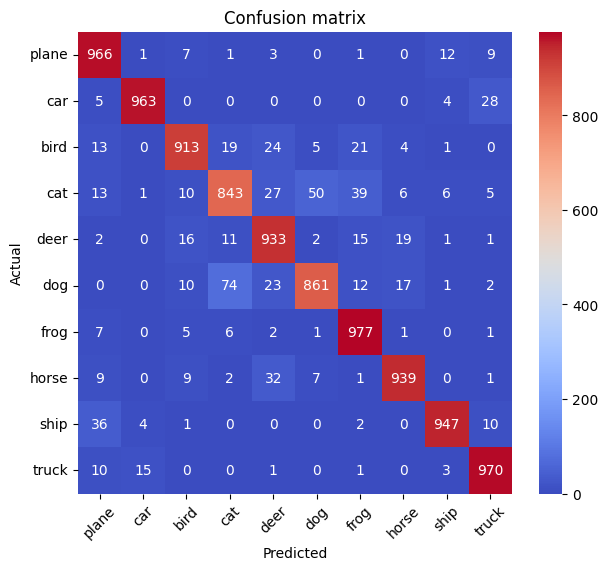

In [69]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)